# Performances of each model on test simulated spectra

### Install project packages

In [4]:
%%bash
pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///data/ar1220/MscProjectNMR
  Attempting uninstall: MscProjectNMR
    Found existing installation: MscProjectNMR 0
    Uninstalling MscProjectNMR-0:
      Successfully uninstalled MscProjectNMR-0
  Running setup.py develop for MscProjectNMR


### Install required python modules

In [ ]:
%%bash
pip install -r ../requirements.txt

### Import fucntions

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from numba import cuda

import joblib

from tfrecords import read_tfrecords_concentrations, read_tfrecords_concentrations_single
from models import get_simple_mutli_regressor_mlp, get_regularised_bn_dropout_mutli_regressor_mlp, CheckpointCallback

In [2]:
tf.__version__

'2.4.2'

---
# I. Read the tf.Record files

## I.7 Test independent dataset (1000 spectra)

In [8]:
test_file_paths = ['../data/tfrecords/Concentrations_data/Test_independent/data_{}.tfrecord'
                               .format(i) for i in range(10)]

test_dataset = read_tfrecords_concentrations(test_file_paths, 16)

In [13]:
X_test = []
y_test = []
for element in test_dataset.unbatch():
    X_test.append(element[0].numpy())
    y_test.append(element[1].numpy())

X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

## I.8 Test correlated dataset (1000 spectra)

In [9]:
test_corr_file_paths = ['../data/tfrecords/Concentrations_data/Test_correlated/data_{}.tfrecord'
                        .format(i) for i in range(10)]

test_corr_dataset = read_tfrecords_concentrations(test_corr_file_paths, 16)

In [13]:
X_test_corr = []
y_test_corr = []
for element in test_corr_dataset.unbatch():
    X_test_corr.append(element[0].numpy())
    y_test_corr.append(element[1].numpy())

X_test_corr = pd.DataFrame(X_test_corr)
y_test_corr = pd.DataFrame(y_test_corr)

## I.9 Test abnormal independent dataset (1000 spectra)

In [10]:
abn_test_file_paths = ['../data/tfrecords/Concentrations_data/Test_abnormal/data_{}.tfrecord'
                               .format(i) for i in range(10)]

abn_test_dataset = read_tfrecords_concentrations(abn_test_file_paths, 16)


In [13]:
X_abn_test = []
y_abn_test = []
for element in abn_test_dataset.unbatch():
    X_abn_test.append(element[0].numpy())
    y_abn_test.append(element[1].numpy())

X_abn_test = pd.DataFrame(X_abn_test)
y_abn_test = pd.DataFrame(y_abn_test)

## I.10 Test correlated dataset (1000 spectra)

In [11]:
abn_test_corr_file_paths = ['../data/tfrecords/Concentrations_data/Test_abnormal_corr/data_{}.tfrecord'
                        .format(i) for i in range(10)]

abn_test_corr_dataset = read_tfrecords_concentrations(abn_test_corr_file_paths, 16)


In [13]:
X_abn_test_corr = []
y_abn_test_corr = []
for element in abn_test_corr_dataset.unbatch():
    X_abn_test_corr.append(element[0].numpy())
    y_abn_test_corr.append(element[1].numpy())

X_abn_test_corr = pd.DataFrame(X_abn_test_corr)
y_abn_test_corr = pd.DataFrame(y_abn_test_corr)

## I.11 Extract each metabolite from small dataset (for independent quantification)

In [3]:
def extract_metabolite(x, y, metab_index):
    return(x, y[..., metab_index])

test_datasets_single = [test_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
test_corr_datasets_single = [test_corr_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
abn_test_datasets_single = [abn_test_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
abn_test_corr_datasets_single = [abn_test_corr_dataset.map(lambda x, y: extract_metabolite(x, y, i))
                                 for i in range(48)]

---
# VIII. Load saved models

## VIII.1 Multi Output MLPs

In [59]:
xsmall_multi_status = (tf.train.Checkpoint(model=xsmall_multi_mlp)
                      .restore(tf.train.latest_checkpoint('../saved_models/concentrations/extra_small_multi'))
                      .expect_partial())
xsmall_multi_status.assert_existing_objects_matched()
xsmall_corr_multi_status = (tf.train.Checkpoint(model=xsmall_corr_multi_mlp)
                           .restore(tf.train.latest_checkpoint('../saved_models/concentrations/extra_small_corr_multi'))
                           .expect_partial())
xsmall_corr_multi_status.assert_existing_objects_matched()
small_multi_status = (tf.train.Checkpoint(model=small_multi_mlp)
                      .restore(tf.train.latest_checkpoint('../saved_models/concentrations/small_multi'))
                      .expect_partial())
small_multi_status.assert_existing_objects_matched()
small_corr_multi_status = (tf.train.Checkpoint(model=small_corr_multi_mlp)
                           .restore(tf.train.latest_checkpoint('../saved_models/concentrations/small_corr_multi'))
                           .expect_partial())
small_corr_multi_status.assert_existing_objects_matched()
large_multi_status = (tf.train.Checkpoint(model=large_multi_mlp)
                      .restore(tf.train.latest_checkpoint('../saved_models/concentrations/large_multi'))
                      .expect_partial())
large_multi_status.assert_existing_objects_matched()
large_corr_multi_status = (tf.train.Checkpoint(model=large_corr_multi_mlp)
                           .restore(tf.train.latest_checkpoint('../saved_models/concentrations/large_corr_multi'))
                           .expect_partial())

## VIII.2 Multi Output RFs

In [60]:
xsmall_multi_RF = joblib.load('../saved_models/concentrations/xsmall_multi_RF')
xsmall_corr_multi_RF = joblib.load('../saved_models/concentrations/xsmall_corr_multi_RF')
small_multi_RF = joblib.load('../saved_models/concentrations/small_multi_RF')
small_corr_multi_RF = joblib.load('../saved_models/concentrations/small_corr_multi_RF')
large_multi_RF = joblib.load('../saved_models/concentrations/large_multi_RF')
large_corr_multi_RF = joblib.load('../saved_models/concentrations/large_corr_multi_RF')

## VIII.3 Single Output MLPs

In [61]:
xsmall_single_status = []
xsmall_corr_single_status = []
small_single_status = []
small_corr_single_status = []
large_single_status = []
large_corr_single_status = []
for i in range(48):
    xsmall_single_status.append((tf.train.Checkpoint(model=xsmall_inde_mlps[i])
                                .restore(tf.train.latest_checkpoint(
                                    '../saved_models/concentrations/extra_small_single/metabolite_{}'.format(i)))
                                .expect_partial()))
    xsmall_single_status[i].assert_existing_objects_matched()
    xsmall_corr_single_status.append((tf.train.Checkpoint(model=xsmall_corr_inde_mlps[i])
                                     .restore(tf.train.latest_checkpoint(
                                         '../saved_models/concentrations/extra_small_corr_single/metabolite_{}'
                                         .format(i)))
                                     .expect_partial()))
    xsmall_corr_single_status[i].assert_existing_objects_matched()
    small_single_status.append((tf.train.Checkpoint(model=small_inde_mlps[i])
                                .restore(tf.train.latest_checkpoint(
                                    '../saved_models/concentrations/small_single/metabolite_{}'.format(i)))
                                .expect_partial()))
    small_single_status[i].assert_existing_objects_matched()
    small_corr_single_status.append((tf.train.Checkpoint(model=small_corr_inde_mlps[i])
                                     .restore(tf.train.latest_checkpoint(
                                         '../saved_models/concentrations/small_corr_single/metabolite_{}'.format(i)))
                                     .expect_partial()))
    small_corr_single_status[i].assert_existing_objects_matched()
    large_single_status.append((tf.train.Checkpoint(model=large_inde_mlps[i])
                                .restore(tf.train.latest_checkpoint(
                                    '../saved_models/concentrations/large_single/metabolite_{}'.format(i)))
                                .expect_partial()))
    large_single_status[i].assert_existing_objects_matched()
    large_corr_single_status.append((tf.train.Checkpoint(model=large_corr_inde_mlps[i])
                                     .restore(tf.train.latest_checkpoint(
                                         '../saved_models/concentrations/large_corr_single/metabolite_{}'.format(i)))
                                     .expect_partial()))
    large_corr_single_status[i].assert_existing_objects_matched()

## VIII.4 Single Output RFs

In [103]:
xsmall_inde_RFs = []
xsmall_corr_inde_RFs = []
small_inde_RFs = []
small_corr_inde_RFs = []
large_inde_RFs = []
large_corr_inde_RFs = []
for i in range(48):
    xsmall_inde_RFs.append(joblib.load('../saved_models/concentrations/xsmall_single_RF/metabolite_{}'.format(i)))
    xsmall_corr_inde_RFs.append(joblib.load('../saved_models/concentrations/xsmall_corr_single_RF/metabolite_{}'
                                           .format(i)))
    small_inde_RFs.append(joblib.load('../saved_models/concentrations/small_single_RF/metabolite_{}'.format(i)))
    small_corr_inde_RFs.append(joblib.load('../saved_models/concentrations/small_corr_single_RF/metabolite_{}'
                                           .format(i)))
    large_inde_RFs.append(joblib.load('../saved_models/concentrations/large_single_RF/metabolite_{}'.format(i)))
    large_corr_inde_RFs.append(joblib.load('../saved_models/concentrations/large_corr_single_RF/metabolite_{}'
                                           .format(i)))

## VIII.5 Partial Least Squares

In [62]:
xsmall_pls = joblib.load('../saved_models/concentrations/xsmall_pls')
xsmall_corr_pls = joblib.load('../saved_models/concentrations/xsmall_corr_pls')
small_pls = joblib.load('../saved_models/concentrations/small_pls')
small_corr_pls = joblib.load('../saved_models/concentrations/small_corr_pls')
large_pls = joblib.load('../saved_models/concentrations/large_pls')
large_corr_pls = joblib.load('../saved_models/concentrations/large_corr_pls')

---
# XI. Performances:

## XI.1. Total RMSE on independent dataset

In [199]:
inde_rmse_xsmall_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=xsmall_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_xsmall_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                           y_pred=xsmall_corr_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_small_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=small_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_small_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                           y_pred=small_corr_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_large_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=large_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_large_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                           y_pred=large_corr_multi_RF.predict(norm_df_spectrum_test))).numpy()


inde_rmse_xsmall_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=xsmall_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_xsmall_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                    y_pred=xsmall_corr_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_small_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=small_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_small_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                    y_pred=small_corr_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_large_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=large_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_large_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                    y_pred=large_corr_pls.predict(norm_df_spectrum_test))).numpy()


rmse_xsmall_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                            y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_test))
                                        for i in range(48)]).numpy()
rmse_xsmall_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                    y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_test))
                                        for i in range(48)]).numpy()
rmse_small_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                            y_pred=small_single_RFs[i].predict(norm_df_spectrum_test))
                                        for i in range(48)]).numpy()
rmse_small_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                    y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_test))
                                        for i in range(48)]).numpy()
rmse_large_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                            y_pred=large_single_RFs[i].predict(norm_df_spectrum_test))
                                        for i in range(48)]).numpy()
rmse_large_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                    y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_test))
                                        for i in range(48)]).numpy()    


inde_rmse_xsmall_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_xsmall_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_small_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_small_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_large_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_large_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()


inde_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
inde_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
inde_rmse_small_multi_mlp = small_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
inde_rmse_small_corr_multi_mlp = small_corr_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']
inde_rmse_large_multi_mlp = large_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
inde_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [200]:
models = ['MLP multi-output',
          'RF multi-output',
          'MLP single-output',
          'PLS']

training_datasets = ['Extra small independent', 'Extra small correlated',
                     'Small independent', 'Small correlated',
                     'Large independent', 'Large correlated']

total_rmse_inde = [[inde_rmse_xsmall_multi_mlp, inde_rmse_xsmall_corr_multi_mlp, inde_rmse_small_multi_mlp,
                   inde_rmse_small_corr_multi_mlp, inde_rmse_large_multi_mlp, inde_rmse_large_corr_multi_mlp],
                  [inde_rmse_xsmall_multi_rf, inde_rmse_xsmall_corr_multi_rf, inde_rmse_small_multi_rf,
                   inde_rmse_small_corr_multi_rf, inde_rmse_large_multi_rf, inde_rmse_large_corr_multi_rf],
                  [inde_rmse_xsmall_single_mlp, inde_rmse_xsmall_corr_single_mlp, inde_rmse_small_single_mlp,
                   inde_rmse_small_corr_single_mlp, inde_rmse_large_single_mlp, inde_rmse_large_corr_single_mlp],
                  [inde_rmse_xsmall_pls, inde_rmse_xsmall_corr_pls, inde_rmse_small_pls,
                   inde_rmse_small_corr_pls, inde_rmse_large_pls, inde_rmse_large_corr_pls]]

In [201]:
table_total_rmse_inde = pd.DataFrame(total_rmse_inde,
                                     index=pd.Index(models, name='Models'),
                                     columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_inde.style.set_caption("Total RMSE evaluated on simulated normal urine with independent metbaolites")

Training sets,Extra small independent,Extra small correlated,Small independent,Small correlated,Large independent,Large correlated
Models,,,,,,
MLP multi-output,0.767992,0.794909,0.539455,0.517958,0.450007,0.424772
RF multi-output,0.956670,0.995738,0.920121,0.956895,0.885071,0.926246
MLP single-output,0.703822,0.705355,0.484899,0.516119,0.413205,0.402602
PLS,0.820953,0.903568,0.694941,0.834876,0.395053,0.427578


## XI.2. Total RMSE on correlated dataset

In [202]:
corr_rmse_xsmall_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=xsmall_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_xsmall_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=xsmall_corr_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_small_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=small_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_small_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=small_corr_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_large_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=large_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_large_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=large_corr_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()


corr_rmse_xsmall_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=xsmall_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_xsmall_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=xsmall_corr_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_small_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=small_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_small_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=small_corr_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_large_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=large_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_large_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=large_corr_pls.predict(norm_df_spectrum_test_corr))).numpy()


rmse_xsmall_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                    y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_test_corr))
                                        for i in range(48)]).numpy()
rmse_xsmall_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_test_corr))
                                        for i in range(48)]).numpy()
rmse_small_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                    y_pred=small_single_RFs[i].predict(norm_df_spectrum_test_corr))
                                        for i in range(48)]).numpy()
rmse_small_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_test_corr))
                                        for i in range(48)]).numpy()
rmse_large_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                    y_pred=large_single_RFs[i].predict(norm_df_spectrum_test_corr))
                                        for i in range(48)]).numpy()
rmse_large_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_test_corr))
                                        for i in range(48)]).numpy()    


corr_rmse_xsmall_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_xsmall_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_small_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_small_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_large_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_large_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()

corr_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
corr_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
corr_rmse_small_multi_mlp = small_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
corr_rmse_small_corr_multi_mlp = small_corr_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']
corr_rmse_large_multi_mlp = large_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
corr_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [203]:
total_rmse_corr = [[corr_rmse_xsmall_multi_mlp, corr_rmse_xsmall_corr_multi_mlp, corr_rmse_small_multi_mlp,
                   corr_rmse_small_corr_multi_mlp, corr_rmse_large_multi_mlp, corr_rmse_large_corr_multi_mlp],
                  [corr_rmse_xsmall_multi_rf, corr_rmse_xsmall_corr_multi_rf, corr_rmse_small_multi_rf,
                   corr_rmse_small_corr_multi_rf, corr_rmse_large_multi_rf, corr_rmse_large_corr_multi_rf],
                  [corr_rmse_xsmall_single_mlp, corr_rmse_xsmall_corr_single_mlp, corr_rmse_small_single_mlp,
                   corr_rmse_small_corr_single_mlp, corr_rmse_large_single_mlp, corr_rmse_large_corr_single_mlp],
                  [corr_rmse_xsmall_pls, corr_rmse_xsmall_corr_pls, corr_rmse_small_pls,
                   corr_rmse_small_corr_pls, corr_rmse_large_pls, corr_rmse_large_corr_pls]]

In [204]:
table_total_rmse_corr = pd.DataFrame(total_rmse_corr, index=pd.Index(models, name='Models'),
                                     columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_corr.style.set_caption("Total RMSE evaluated on simulated normal urine with correlated metbaolites")

Training sets,Extra small independent,Extra small correlated,Small independent,Small correlated,Large independent,Large correlated
Models,,,,,,
MLP multi-output,1.414517,0.805379,0.837840,0.527440,0.589939,0.427964
RF multi-output,1.708038,1.076362,1.679987,0.986860,1.660469,0.934846
MLP single-output,1.569969,0.719167,0.802672,0.523690,0.592365,0.408844
PLS,1.490953,1.120332,0.900915,0.880171,0.428435,0.433337


## XI.3. Total RMSE on abnormal independent dataset

In [196]:
abn_inde_rmse_xsmall_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=xsmall_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_xsmall_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                  y_pred=xsmall_corr_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_small_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=small_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_small_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                  y_pred=small_corr_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_large_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=large_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_large_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                  y_pred=large_corr_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()


abn_inde_rmse_xsmall_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=xsmall_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_xsmall_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                    y_pred=xsmall_corr_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_small_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=small_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_small_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                    y_pred=small_corr_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_large_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=large_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_large_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                    y_pred=large_corr_pls.predict(norm_df_spectrum_abn_test))).numpy()


rmse_xsmall_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                  y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_abn_test))
                                        for i in range(48)]).numpy()
rmse_xsmall_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                  y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_abn_test))
                                        for i in range(48)]).numpy()
rmse_small_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                            y_pred=small_single_RFs[i].predict(norm_df_spectrum_abn_test))
                                        for i in range(48)]).numpy()
rmse_small_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                    y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_abn_test))
                                        for i in range(48)]).numpy()
rmse_large_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                            y_pred=large_single_RFs[i].predict(norm_df_spectrum_abn_test))
                                        for i in range(48)]).numpy()
rmse_large_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                    y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_abn_test))
                                        for i in range(48)]).numpy()   


abn_inde_rmse_xsmall_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_xsmall_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_small_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_small_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_large_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_large_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()


abn_inde_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
abn_inde_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
abn_inde_rmse_small_multi_mlp = small_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
abn_inde_rmse_small_corr_multi_mlp = small_corr_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']
abn_inde_rmse_large_multi_mlp = large_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
abn_inde_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [205]:
total_rmse_abn_inde = [[abn_inde_rmse_xsmall_multi_mlp, abn_inde_rmse_xsmall_corr_multi_mlp, abn_inde_rmse_small_multi_mlp,
                   abn_inde_rmse_small_corr_multi_mlp, abn_inde_rmse_large_multi_mlp, abn_inde_rmse_large_corr_multi_mlp],
                  [abn_inde_rmse_xsmall_multi_rf, abn_inde_rmse_xsmall_corr_multi_rf, abn_inde_rmse_small_multi_rf,
                   abn_inde_rmse_small_corr_multi_rf, abn_inde_rmse_large_multi_rf, abn_inde_rmse_large_corr_multi_rf],
                  [abn_inde_rmse_xsmall_single_mlp, abn_inde_rmse_xsmall_corr_single_mlp, abn_inde_rmse_small_single_mlp,
                   abn_inde_rmse_small_corr_single_mlp, abn_inde_rmse_large_single_mlp, abn_inde_rmse_large_corr_single_mlp],
                  [abn_inde_rmse_xsmall_pls, abn_inde_rmse_xsmall_corr_pls, abn_inde_rmse_small_pls,
                   abn_inde_rmse_small_corr_pls, abn_inde_rmse_large_pls, abn_inde_rmse_large_corr_pls]]

In [206]:
table_total_rmse_abn_inde = pd.DataFrame(total_rmse_abn_inde, index=pd.Index(models, name='Models'),
                                   columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_abn_inde.style.set_caption("Total RMSE evaluated on simulated abnormal urine with independent metbaolites")

Training sets,Extra small independent,Extra small correlated,Small independent,Small correlated,Large independent,Large correlated
Models,,,,,,
MLP multi-output,5.560747,5.251982,3.751281,3.473174,3.270526,3.176565
RF multi-output,7.601979,7.531071,7.562302,7.560727,7.483423,7.546793
MLP single-output,5.200213,4.789392,4.227948,3.893135,4.980217,4.375819
PLS,6.114450,5.877680,2.071791,5.144246,0.533516,0.611099


## XI.4. Total RMSE on abnromal correlated dataset

In [193]:
abn_corr_rmse_xsmall_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=xsmall_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_xsmall_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                y_pred=xsmall_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_small_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=small_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_small_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                y_pred=small_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_large_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=large_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_large_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                y_pred=large_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()


abn_corr_rmse_xsmall_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=xsmall_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_xsmall_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                    y_pred=xsmall_corr_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_small_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=small_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_small_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                    y_pred=small_corr_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_large_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=large_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_large_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                    y_pred=large_corr_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()


rmse_xsmall_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                    y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
                                        for i in range(48)]).numpy()
rmse_xsmall_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
                                        for i in range(48)]).numpy()
rmse_small_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                    y_pred=small_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
                                        for i in range(48)]).numpy()
rmse_small_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
                                        for i in range(48)]).numpy()
rmse_large_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                    y_pred=large_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
                                        for i in range(48)]).numpy()
rmse_large_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
                                        for i in range(48)]).numpy()     


abn_corr_rmse_xsmall_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_xsmall_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_small_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_small_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_large_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_large_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()


abn_corr_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
abn_corr_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
abn_corr_rmse_small_multi_mlp = small_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
abn_corr_rmse_small_corr_multi_mlp = small_corr_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']
abn_corr_rmse_large_multi_mlp = large_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
abn_corr_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [197]:
total_rmse_abn_corr = [[abn_corr_rmse_xsmall_multi_mlp, abn_corr_rmse_xsmall_corr_multi_mlp, abn_corr_rmse_small_multi_mlp,
                   abn_corr_rmse_small_corr_multi_mlp, abn_corr_rmse_large_multi_mlp, abn_corr_rmse_large_corr_multi_mlp],
                  [abn_corr_rmse_xsmall_multi_rf, abn_corr_rmse_xsmall_corr_multi_rf, abn_corr_rmse_small_multi_rf,
                   abn_corr_rmse_small_corr_multi_rf, abn_corr_rmse_large_multi_rf, abn_corr_rmse_large_corr_multi_rf],
                  [abn_corr_rmse_xsmall_single_mlp, abn_corr_rmse_xsmall_corr_single_mlp, abn_corr_rmse_small_single_mlp,
                   abn_corr_rmse_small_corr_single_mlp, abn_corr_rmse_large_single_mlp, abn_corr_rmse_large_corr_single_mlp],
                  [abn_corr_rmse_xsmall_pls, abn_corr_rmse_xsmall_corr_pls, abn_corr_rmse_small_pls,
                   abn_corr_rmse_small_corr_pls, abn_corr_rmse_large_pls, abn_corr_rmse_large_corr_pls]]

In [207]:
table_total_rmse_abn_corr = pd.DataFrame(total_rmse_abn_corr, index=pd.Index(models, name='Models'),
                                         columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_abn_corr.style.set_caption("Total RMSE evaluated on simulated abnormal urine with correlated metbaolites")

Training sets,Extra small independent,Extra small correlated,Small independent,Small correlated,Large independent,Large correlated
Models,,,,,,
MLP multi-output,5.413130,5.190428,3.674946,3.355803,3.106043,3.023183
RF multi-output,7.460204,7.402550,7.432291,7.434803,7.343335,7.402838
MLP single-output,5.007328,4.712090,4.094810,3.772734,4.821761,4.217957
PLS,5.991049,5.820400,2.040228,5.126068,0.405766,0.512542


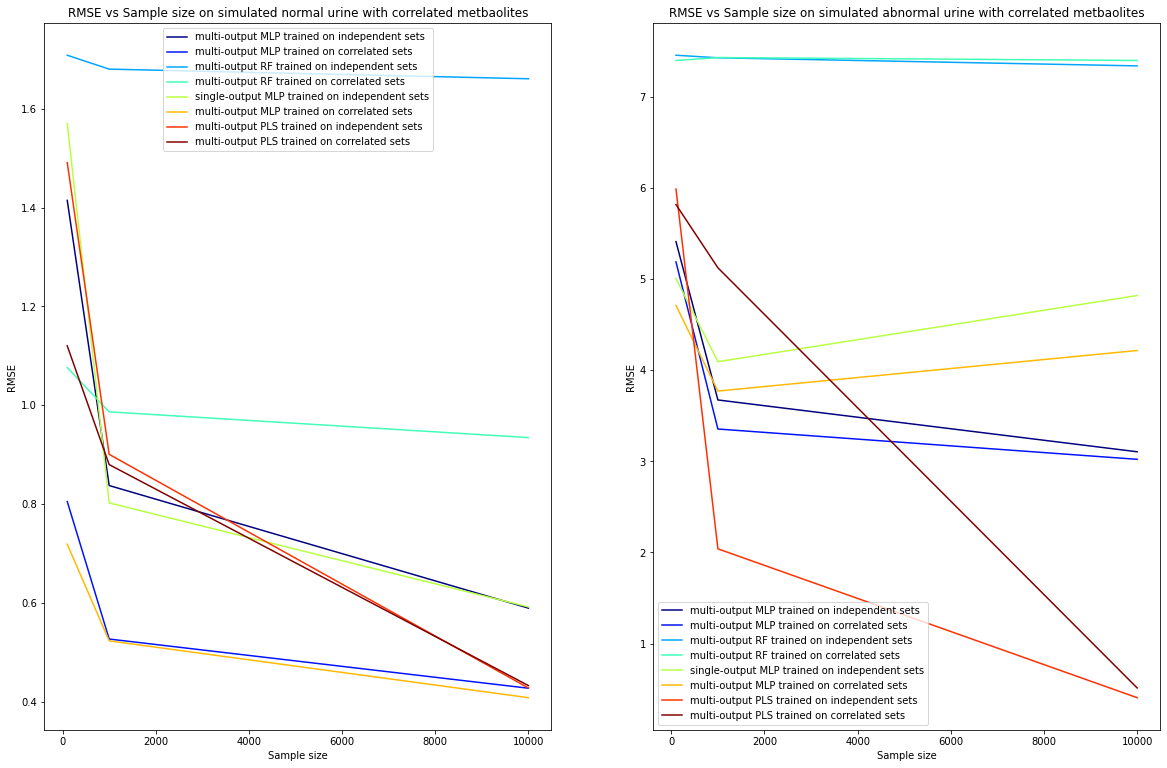

In [230]:
sample_sizes = [100, 1000, 10000]
# inde_mlp_multi_abn_inde = [abn_inde_rmse_xsmall_multi_mlp, abn_inde_rmse_small_multi_mlp, abn_inde_rmse_large_multi_mlp]
# inde_RF_multi_abn_inde = [abn_inde_rmse_xsmall_multi_rf, abn_inde_rmse_small_multi_rf, abn_inde_rmse_large_multi_rf]
# inde_mlp_single_abn_inde = [abn_inde_rmse_xsmall_single_mlp, abn_inde_rmse_small_single_mlp, abn_inde_rmse_large_single_mlp]
# inde_pls_multi_abn_inde = [abn_inde_rmse_xsmall_pls, abn_inde_rmse_small_pls, abn_inde_rmse_large_pls]
# corr_mlp_multi_abn_inde = [abn_inde_rmse_xsmall_corr_multi_mlp, abn_inde_rmse_small_corr_multi_mlp, abn_inde_rmse_large_corr_multi_mlp]
# corr_RF_multi_abn_inde = [abn_inde_rmse_xsmall_corr_multi_rf, abn_inde_rmse_small_corr_multi_rf, abn_inde_rmse_large_corr_multi_rf]
# corr_mlp_single_abn_inde = [abn_inde_rmse_xsmall_corr_single_mlp, abn_inde_rmse_small_corr_single_mlp, abn_inde_rmse_large_corr_single_mlp]
# corr_pls_multi_abn_inde = [abn_inde_rmse_xsmall_corr_pls, abn_inde_rmse_small_corr_pls, abn_inde_rmse_large_corr_pls]

inde_mlp_multi_abn_corr = [abn_corr_rmse_xsmall_multi_mlp, abn_corr_rmse_small_multi_mlp, abn_corr_rmse_large_multi_mlp]
inde_RF_multi_abn_corr = [abn_corr_rmse_xsmall_multi_rf, abn_corr_rmse_small_multi_rf, abn_corr_rmse_large_multi_rf]
inde_mlp_single_abn_corr = [abn_corr_rmse_xsmall_single_mlp, abn_corr_rmse_small_single_mlp, abn_corr_rmse_large_single_mlp]
inde_pls_multi_abn_corr = [abn_corr_rmse_xsmall_pls, abn_corr_rmse_small_pls, abn_corr_rmse_large_pls]
corr_mlp_multi_abn_corr = [abn_corr_rmse_xsmall_corr_multi_mlp, abn_corr_rmse_small_corr_multi_mlp, abn_corr_rmse_large_corr_multi_mlp]
corr_RF_multi_abn_corr = [abn_corr_rmse_xsmall_corr_multi_rf, abn_corr_rmse_small_corr_multi_rf, abn_corr_rmse_large_corr_multi_rf]
corr_mlp_single_abn_corr = [abn_corr_rmse_xsmall_corr_single_mlp, abn_corr_rmse_small_corr_single_mlp, abn_corr_rmse_large_corr_single_mlp]
corr_pls_multi_abn_corr = [abn_corr_rmse_xsmall_corr_pls, abn_corr_rmse_small_corr_pls, abn_corr_rmse_large_corr_pls]

inde_mlp_multi_corr = [corr_rmse_xsmall_multi_mlp, corr_rmse_small_multi_mlp, corr_rmse_large_multi_mlp]
inde_RF_multi_corr = [corr_rmse_xsmall_multi_rf, corr_rmse_small_multi_rf, corr_rmse_large_multi_rf]
inde_mlp_single_corr = [corr_rmse_xsmall_single_mlp, corr_rmse_small_single_mlp, corr_rmse_large_single_mlp]
inde_pls_multi_corr = [corr_rmse_xsmall_pls, corr_rmse_small_pls, corr_rmse_large_pls]
corr_mlp_multi_corr = [corr_rmse_xsmall_corr_multi_mlp, corr_rmse_small_corr_multi_mlp, corr_rmse_large_corr_multi_mlp]
corr_RF_multi_corr = [corr_rmse_xsmall_corr_multi_rf, corr_rmse_small_corr_multi_rf, corr_rmse_large_corr_multi_rf]
corr_mlp_single_corr = [corr_rmse_xsmall_corr_single_mlp, corr_rmse_small_corr_single_mlp, corr_rmse_large_corr_single_mlp]
corr_pls_multi_corr = [corr_rmse_xsmall_corr_pls, corr_rmse_small_corr_pls, corr_rmse_large_corr_pls]


colors = plt.cm.jet(np.linspace(0,1,8))

fig = plt.figure(figsize=(20, 13))

fig.add_subplot(121)
plt.plot(sample_sizes, inde_mlp_multi_corr, label='multi-output MLP trained on independent sets', color=colors[0], linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color=colors[1], linestyle='-')
plt.plot(sample_sizes, inde_RF_multi_corr, label='multi-output RF trained on independent sets', color=colors[2], linestyle='-')
plt.plot(sample_sizes, corr_RF_multi_corr, label='multi-output RF trained on correlated sets', color=colors[3], linestyle='-')
plt.plot(sample_sizes, inde_mlp_single_corr, label='single-output MLP trained on independent sets', color=colors[4], linestyle='-')
plt.plot(sample_sizes, corr_mlp_single_corr, label='multi-output MLP trained on correlated sets', color=colors[5], linestyle='-')
plt.plot(sample_sizes, inde_pls_multi_corr, label='multi-output PLS trained on independent sets', color=colors[6], linestyle='-')
plt.plot(sample_sizes, corr_pls_multi_corr, label='multi-output PLS trained on correlated sets', color=colors[7], linestyle='-')
plt.title("RMSE vs Sample size on simulated normal urine with correlated metbaolites")
plt.xlabel("Sample size")
plt.ylabel("RMSE")
plt.legend()
# fig.add_subplot(121)
# plt.plot(sample_sizes, inde_mlp_multi_abn_inde, label='multi-output MLP trained on independent sets', color=colors[0], linestyle='-')
# plt.plot(sample_sizes, corr_mlp_multi_abn_inde, label='multi-output MLP trained on correlated sets', color=colors[1], linestyle='-')
# plt.plot(sample_sizes, inde_RF_multi_abn_inde, label='multi-output RF trained on independent sets', color=colors[2], linestyle='-')
# plt.plot(sample_sizes, corr_RF_multi_abn_inde, label='multi-output RF trained on correlated sets', color=colors[3], linestyle='-')
# plt.plot(sample_sizes, inde_mlp_single_abn_inde, label='single-output MLP trained on independent sets', color=colors[4], linestyle='-')
# plt.plot(sample_sizes, corr_mlp_single_abn_inde, label='multi-output MLP trained on correlated sets', color=colors[5], linestyle='-')
# plt.plot(sample_sizes, inde_pls_multi_abn_inde, label='multi-output PLS trained on independent sets', color=colors[6], linestyle='-')
# plt.plot(sample_sizes, corr_pls_multi_abn_inde, label='multi-output PLS trained on correlated sets', color=colors[7], linestyle='-')
# plt.title("RMSE vs Sample size on simulated abnormal urine with independent metbaolites")
# plt.xlabel("Sample size")
# plt.ylabel("RMSE")
# plt.legend()

fig.add_subplot(122)
plt.plot(sample_sizes, inde_mlp_multi_abn_corr, label='multi-output MLP trained on independent sets', color=colors[0], linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_abn_corr, label='multi-output MLP trained on correlated sets', color=colors[1], linestyle='-')
plt.plot(sample_sizes, inde_RF_multi_abn_corr, label='multi-output RF trained on independent sets', color=colors[2], linestyle='-')
plt.plot(sample_sizes, corr_RF_multi_abn_corr, label='multi-output RF trained on correlated sets', color=colors[3], linestyle='-')
plt.plot(sample_sizes, inde_mlp_single_abn_corr, label='single-output MLP trained on independent sets', color=colors[4], linestyle='-')
plt.plot(sample_sizes, corr_mlp_single_abn_corr, label='multi-output MLP trained on correlated sets', color=colors[5], linestyle='-')
plt.plot(sample_sizes, inde_pls_multi_abn_corr, label='multi-output PLS trained on independent sets', color=colors[6], linestyle='-')
plt.plot(sample_sizes, corr_pls_multi_abn_corr, label='multi-output PLS trained on correlated sets', color=colors[7], linestyle='-')
plt.title("RMSE vs Sample size on simulated abnormal urine with correlated metbaolites")
plt.xlabel("Sample size")
plt.ylabel("RMSE")
plt.legend()

plt.show()

In [ ]:
sample_sizes = [100, 1000, 10000]
inde_mlp_multi_inde = [inde_rmse_xsmall_multi_mlp, inde_rmse_small_multi_mlp, inde_rmse_large_multi_mlp]
inde_RF_multi_inde = [inde_rmse_xsmall_multi_RF, inde_rmse_small_multi_RF, inde_rmse_large_multi_RF]
inde_mlp_single_inde = [inde_rmse_xsmall_single_mlp, inde_rmse_small_single_mlp, inde_rmse_large_single_mlp]
inde_pls_multi_inde = [inde_rmse_xsmall_pls, inde_rmse_small_pls, inde_rmse_large_pls]
corr_mlp_multi_inde = [inde_rmse_xsmall_inde_multi_mlp, inde_rmse_small_inde_multi_mlp, inde_rmse_large_corr_multi_mlp]
corr_RF_multi_inde = [inde_rmse_xsmall_inde_multi_RF, ande_rmse_small_inde_multi_RF, inde_rmse_large_corr_multi_RF]
corr_mlp_single_inde = [inde_rmse_xsmall_inde_single_mlp, inde_rmse_small_inde_single_mlp, inde_rmse_large_corr_single_mlp]
corr_pls_multi_inde = [inde_rmse_xsmall_inde_pls, inde_rmse_small_corr_pls, inde_rmse_large_corr_pls]

inde_mlp_multi_corr = [corr_rmse_xsmall_multi_mlp, corr_rmse_small_multi_mlp, corr_rmse_large_multi_mlp]
inde_RF_multi_corr = [corr_rmse_xsmall_multi_RF, corr_rmse_small_multi_RF, corr_rmse_large_multi_RF]
inde_mlp_single_corr = [corr_rmse_xsmall_single_mlp, corr_rmse_small_single_mlp, corr_rmse_large_single_mlp]
inde_pls_multi_corr = [corr_rmse_xsmall_pls, corr_rmse_small_pls, corr_rmse_large_pls]
corr_mlp_multi_corr = [corr_rmse_xsmall_corr_multi_mlp, corr_rmse_small_corr_multi_mlp, corr_rmse_large_corr_multi_mlp]
corr_RF_multi_corr = [corr_rmse_xsmall_corr_multi_RF, corr_rmse_small_corr_multi_RF, corr_rmse_large_corr_multi_RF]
corr_mlp_single_corr = [corr_rmse_xsmall_corr_single_mlp, corr_rmse_small_corr_single_mlp, corr_rmse_large_corr_single_mlp]
corr_pls_multi_corr = [corr_rmse_xsmall_corr_pls, corr_rmse_small_corr_pls, corr_rmse_large_corr_pls]

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(sample_sizes, inde_mlp_multi_inde, label='multi-output MLP trained on independent sets', color='C0', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_inde, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_inde, label='multi-output RF trained on independent sets', color='C1', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_inde, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_inde, label='single-output MLP trained on independent sets', color='C2', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_inde, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_inde, label='multi-output PLS trained on independent sets', color='C3', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_inde, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.title("RMSE vs Sample size on simulated normal urine with independent metbaolites")
plt.xlabel("Sample size")
plt.ylabel("RMSE")
plt.legend()

fig.add_subplot(121)
plt.plot(sample_sizes, inde_mlp_multi_corr, label='multi-output MLP trained on independent sets', color='C0', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_corr, label='multi-output RF trained on independent sets', color='C1', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_corr, label='single-output MLP trained on independent sets', color='C2', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_corr, label='multi-output PLS trained on independent sets', color='C3', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.title("RMSE vs Sample size on simulated normal urine with correlated metbaolites")
plt.xlabel("Sample size")
plt.ylabel("RMSE")
plt.legend()

plt.show()

## XI.4. Metabolite wise $R^{2}$ on independent dataset

### XI.4.a Import mean concentration data and metabolites

In [120]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.4.b Extract ground truth from validation set

In [121]:
true_val = []
for batch in test_dataset:
    true_val.append(batch[1])
y_val = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [122]:
inde_SS_total = tf.reduce_mean(tf.math.square(y_val), axis=0).numpy()
inde_SS_total = pd.Series(inde_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.4.c Multi output MLPs

In [123]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(test_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(test_dataset)
y_pred_small_multi_mlp = small_multi_mlp.predict(test_dataset)
y_pred_small_corr_multi_mlp = small_corr_multi_mlp.predict(test_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(test_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(test_dataset)


inde_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_multi_mlp), axis=0).numpy()
inde_R_xsmall_multi_mlp = 1 - inde_SS_res_xsmall_multi_mlp/inde_SS_total
inde_R_xsmall_multi_mlp = pd.Series(inde_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

inde_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
inde_R_xsmall_corr_multi_mlp = 1 - inde_SS_res_xsmall_corr_multi_mlp/inde_SS_total
inde_R_xsmall_corr_multi_mlp = pd.Series(inde_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

inde_SS_res_small_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_small_multi_mlp), axis=0).numpy()
inde_R_small_multi_mlp = 1 - inde_SS_res_small_multi_mlp/inde_SS_total
inde_R_small_multi_mlp = pd.Series(inde_R_small_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on small set')

inde_SS_res_small_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_small_corr_multi_mlp),
                                                  axis=0).numpy()
inde_R_small_corr_multi_mlp = 1 - inde_SS_res_small_corr_multi_mlp/inde_SS_total
inde_R_small_corr_multi_mlp = pd.Series(inde_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on small correlated set')

inde_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_large_multi_mlp), axis=0).numpy()
inde_R_large_multi_mlp = 1 - inde_SS_res_large_multi_mlp/inde_SS_total
inde_R_large_multi_mlp = pd.Series(inde_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

inde_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
inde_R_large_corr_multi_mlp = 1 - inde_SS_res_large_corr_multi_mlp/inde_SS_total
inde_R_large_corr_multi_mlp = pd.Series(inde_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.4.d Multi output RFs

In [124]:
y_pred_xsmall_multi_RF = xsmall_multi_RF.predict(norm_df_spectrum_test)
y_pred_xsmall_corr_multi_RF = xsmall_corr_multi_RF.predict(norm_df_spectrum_test)
y_pred_small_multi_RF = small_multi_RF.predict(norm_df_spectrum_test)
y_pred_small_corr_multi_RF = small_corr_multi_RF.predict(norm_df_spectrum_test)
y_pred_large_multi_RF = large_multi_RF.predict(norm_df_spectrum_test)
y_pred_large_corr_multi_RF = large_corr_multi_RF.predict(norm_df_spectrum_test)

inde_SS_res_xsmall_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_multi_RF), axis=0).numpy()
inde_R_xsmall_multi_RF = 1 - inde_SS_res_xsmall_multi_RF/inde_SS_total
inde_R_xsmall_multi_RF = pd.Series(inde_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on extra small set')

inde_SS_res_xsmall_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_corr_multi_RF),
                                                  axis=0).numpy()
inde_R_xsmall_corr_multi_RF = 1 - inde_SS_res_xsmall_corr_multi_RF/inde_SS_total
inde_R_xsmall_corr_multi_RF = pd.Series(inde_R_xsmall_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on extra small correlated set')

inde_SS_res_small_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_small_multi_RF), axis=0).numpy()
inde_R_small_multi_RF = 1 - inde_SS_res_small_multi_RF/inde_SS_total
inde_R_small_multi_RF = pd.Series(inde_R_small_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on small set')

inde_SS_res_small_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_small_corr_multi_RF),
                                                  axis=0).numpy()
inde_R_small_corr_multi_RF = 1 - inde_SS_res_small_corr_multi_RF/inde_SS_total
inde_R_small_corr_multi_RF = pd.Series(inde_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on small correlated set')

inde_SS_res_large_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_large_multi_RF), axis=0).numpy()
inde_R_large_multi_RF = 1 - inde_SS_res_large_multi_RF/inde_SS_total
inde_R_large_multi_RF = pd.Series(inde_R_large_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on large set')

inde_SS_res_large_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_large_corr_multi_RF),
                                                  axis=0).numpy()
inde_R_large_corr_multi_RF = 1 - inde_SS_res_large_corr_multi_RF/inde_SS_total
inde_R_large_corr_multi_RF = pd.Series(inde_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on large correlated set')

### XI.4.e Single output MLPs

In [125]:
inde_SS_res_xsmall_single_mlp = [xsmall_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_xsmall_single_mlp = 1 - inde_SS_res_xsmall_single_mlp/inde_SS_total
inde_R_xsmall_single_mlp = pd.Series(inde_R_xsmall_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on extra small set')

inde_SS_res_xsmall_corr_single_mlp = [xsmall_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_xsmall_corr_single_mlp = 1 - inde_SS_res_xsmall_corr_single_mlp/inde_SS_total
inde_R_xsmall_corr_single_mlp = pd.Series(inde_R_xsmall_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on extra small correlated set')

inde_SS_res_small_single_mlp = [small_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_small_single_mlp = 1 - inde_SS_res_small_single_mlp/inde_SS_total
inde_R_small_single_mlp = pd.Series(inde_R_small_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on small set')

inde_SS_res_small_corr_single_mlp = [small_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_small_corr_single_mlp = 1 - inde_SS_res_small_corr_single_mlp/inde_SS_total
inde_R_small_corr_single_mlp = pd.Series(inde_R_small_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on small correlated set')

inde_SS_res_large_single_mlp = [large_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_large_single_mlp = 1 - inde_SS_res_large_single_mlp/inde_SS_total
inde_R_large_single_mlp = pd.Series(inde_R_large_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on large set')

inde_SS_res_large_corr_single_mlp = [large_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_large_corr_single_mlp = 1 - inde_SS_res_large_corr_single_mlp/inde_SS_total
inde_R_large_corr_single_mlp = pd.Series(inde_R_large_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on large correlated set')


### XI.4.f Single output RFs

In [ ]:
inde_ew_rmse_xsmall_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                          y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_test)))
                               for i in range(48)]
inde_ew_rmse_xsmall_single_RF = pd.Series(inde_ew_rmse_xsmall_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

inde_ew_rmse_xsmall_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                    y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_test)))
                                    for i in range(48)]
inde_ew_rmse_xsmall_corr_single_RF = pd.Series(inde_ew_rmse_xsmall_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

inde_ew_rmse_small_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                          y_pred=small_single_RFs[i].predict(norm_df_spectrum_test)))
                               for i in range(48)]
inde_ew_rmse_small_single_RF = pd.Series(inde_ew_rmse_small_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

inde_ew_rmse_small_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                    y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_test)))
                                    for i in range(48)]
inde_ew_rmse_small_corr_single_RF = pd.Series(inde_ew_rmse_small_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

inde_ew_rmse_large_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                          y_pred=large_single_RFs[i].predict(norm_df_spectrum_test)))
                               for i in range(48)]
inde_ew_rmse_large_single_RF = pd.Series(inde_ew_rmse_large_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large set')

inde_ew_rmse_large_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                    y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_test)))
                                    for i in range(48)]
inde_ew_rmse_large_corr_single_RF = pd.Series(inde_ew_rmse_large_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large correlated set')


### XI.4.g PLS

In [126]:
y_pred_xsmall_pls = xsmall_pls.predict(norm_df_spectrum_test)
y_pred_xsmall_corr_pls = xsmall_corr_pls.predict(norm_df_spectrum_test)
y_pred_small_pls = small_pls.predict(norm_df_spectrum_test)
y_pred_small_corr_pls = small_corr_pls.predict(norm_df_spectrum_test)
y_pred_large_pls = large_pls.predict(norm_df_spectrum_test)
y_pred_large_corr_pls = large_corr_pls.predict(norm_df_spectrum_test)


inde_SS_res_xsmall_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_pls), axis=0).numpy()
inde_R_xsmall_pls = 1 - inde_SS_res_xsmall_multi_RF/inde_SS_total
inde_R_xsmall_pls = pd.Series(inde_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on extra small set')

inde_SS_res_xsmall_corr_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_corr_pls),
                                                  axis=0).numpy()
inde_R_xsmall_corr_pls = 1 - inde_SS_res_xsmall_corr_pls/inde_SS_total
inde_R_xsmall_corr_pls = pd.Series(inde_R_xsmall_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on extra small correlated set')

inde_SS_res_small_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_small_pls), axis=0).numpy()
inde_R_small_pls = 1 - inde_SS_res_small_pls/inde_SS_total
inde_R_small_pls = pd.Series(inde_R_small_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on small set')

inde_SS_res_small_corr_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_small_corr_pls),
                                                  axis=0).numpy()
inde_R_small_corr_pls = 1 - inde_SS_res_small_corr_pls/inde_SS_total
inde_R_small_corr_pls = pd.Series(inde_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on small correlated set')

inde_SS_res_large_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_large_pls), axis=0).numpy()
inde_R_large_pls = 1 - inde_SS_res_large_pls/inde_SS_total
inde_R_large_pls = pd.Series(inde_R_large_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on large set')

inde_SS_res_large_corr_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_large_corr_pls),
                                                  axis=0).numpy()
inde_R_large_corr_pls = 1 - inde_SS_res_large_corr_pls/inde_SS_total
inde_R_large_corr_pls = pd.Series(inde_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on large correlated set')

### XI.4.i Create the table

In [ ]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
(summary_table_small.style
  .background_gradient(cmap=cm))

In [127]:
def color_traget(cell):
    colors = ['lightgreen' if cell[i] > 0 else 'lightcoral' for i in range(8)] + ['white']
    return ['background-color: %s' % color for color in colors]


def font_min_RMSE(cell):
    fonts = ['bold' if (1 - cell[i]) == min(1 - cell[:8]) else '' for i in range (8)] + ['']
    return ['font-weight: %s' % font for font in fonts]

In [128]:
# target = pd.Series(mean_concentrations/sd_concentrations * 0.3, index=metabolites, name='Target RMSE')

summary_table_xsmall = pd.concat([inde_R_xsmall_multi_mlp, inde_R_xsmall_single_mlp,
                                  inde_R_xsmall_multi_RF, inde_R_xsmall_pls,
                                  inde_R_xsmall_corr_multi_mlp, inde_R_xsmall_corr_single_mlp, 
                                  inde_R_xsmall_corr_multi_RF, inde_R_xsmall_corr_pls,
                                  inde_SS_total], axis=1)
summary_table_small = pd.concat([inde_R_small_multi_mlp, inde_R_small_single_mlp,
                                 inde_R_small_multi_RF, inde_R_small_pls,
                                 inde_R_small_corr_multi_mlp, inde_R_small_corr_single_mlp,
                                 inde_R_small_corr_multi_RF, inde_R_small_corr_pls,
                                 inde_SS_total], axis=1)
summary_table_large = pd.concat([inde_R_large_multi_mlp, inde_R_large_single_mlp,
                                 inde_R_large_multi_RF, inde_R_large_pls,
                                 inde_R_large_corr_multi_mlp, inde_R_large_corr_single_mlp,
                                 inde_R_large_corr_multi_RF, inde_R_large_corr_pls,
                                 inde_SS_total], axis=1)

In [129]:
summary_table_xsmall.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on extra small set,R² single-output RF trained on extra small set,R² muti-output RF trained on extra small set,R² PLS trained on extra small set,R² muti-output MLP trained on extra small correlated set,R² single-output RF trained on extra small correlated set,R² muti-output RF trained on extra small correlated set,R² PLS trained on extra small correlated set,Total Sum of Squares
Creatinine,0.996117,0.999539,-0.213989,-0.213989,0.996181,0.999425,-0.252829,-0.640598,1.050550
Hippuric_acid,0.995479,0.999025,-0.090747,-0.090747,0.994126,0.998710,-0.127663,-0.510409,0.895423
Citric_acid,0.991461,0.997273,-0.158070,-0.158070,0.958486,0.989199,-0.251529,-0.390202,0.799125
Glycine,0.962363,0.983334,-0.141396,-0.141396,0.933409,0.971525,-0.270842,-0.360442,0.837392
TMAO,0.994994,0.999637,0.020737,0.020737,0.992526,0.999678,-0.175467,-0.098787,0.663882
Histidine,0.914374,0.964057,-0.093185,-0.093185,0.921329,0.964847,-0.116149,-0.297428,0.981033
phenylacetylglutamine,0.503994,0.718458,-0.084918,-0.084918,0.587950,0.714317,-0.158965,-0.411180,0.991677
Taurine,0.951296,0.981012,-0.042625,-0.042625,0.963507,0.989081,-0.177466,-0.238883,0.803844
glycolic_acid,0.884073,0.939169,-0.076701,-0.076701,0.822245,0.932560,-0.168997,-0.209554,0.938590
Formate,0.676787,0.004972,-0.114814,-0.114814,0.688707,0.784752,-0.148884,-0.198579,0.896775


In [130]:
summary_table_small.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on small set,R² single-output RF trained on small set,R² muti-output RF trained on small set,R² PLS trained on small set,R² muti-output MLP trained on small correlated set,R² single-output RF trained on small correlated set,R² muti-output RF trained on small correlated set,R² PLS trained on small correlated set,Total Sum of Squares
Creatinine,0.996274,0.999920,-0.277015,-1.034720,0.998566,0.999921,-0.238343,-0.707005,1.050550
Hippuric_acid,0.997187,0.999825,-0.106211,-0.877090,0.994063,0.999839,-0.181402,-0.803100,0.895423
Citric_acid,0.997300,0.999497,-0.155652,-0.859706,0.995332,0.999435,-0.236714,-0.453613,0.799125
Glycine,0.990988,0.998611,-0.119491,-0.672559,0.992944,0.997982,-0.314957,-0.419880,0.837392
TMAO,0.994190,0.999943,-0.025140,-0.606340,0.996621,0.999924,0.002510,-0.262713,0.663882
Histidine,0.991644,0.996806,-0.105388,-0.861863,0.991112,0.997366,-0.168450,-0.737522,0.981033
phenylacetylglutamine,0.956166,0.977918,-0.145097,-0.839763,0.953213,0.980325,-0.038274,-0.696221,0.991677
Taurine,0.988909,0.997875,-0.046536,-0.724499,0.989238,0.997939,-0.109960,-0.513910,0.803844
glycolic_acid,0.983087,0.997349,-0.112789,-0.699491,0.990180,0.997418,-0.080028,-0.028095,0.938590
Formate,0.977181,0.992239,-0.067131,-0.796407,0.968387,0.992140,-0.097324,-0.046312,0.896775


In [131]:
summary_table_large.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on large set,R² single-output RF trained on large set,R² muti-output RF trained on large set,R² PLS trained on large set,R² muti-output MLP trained on large correlated set,R² single-output RF trained on large correlated set,R² muti-output RF trained on large correlated set,R² PLS trained on large correlated set,Total Sum of Squares
Creatinine,0.998075,0.999837,-0.302315,-1.046440,0.998566,0.999943,-0.238343,-0.707005,1.050550
Hippuric_acid,0.998223,0.999850,-0.157913,-0.935911,0.994063,0.999874,-0.181402,-0.803100,0.895423
Citric_acid,0.997500,0.999319,-0.142388,-0.929662,0.995332,0.999399,-0.236714,-0.453613,0.799125
Glycine,0.994048,0.995132,-0.161687,-1.097659,0.992944,0.997402,-0.314957,-0.419880,0.837392
TMAO,0.997133,0.999858,-0.011719,-0.794056,0.996621,0.999966,0.002510,-0.262713,0.663882
Histidine,0.990686,0.997725,-0.217340,-0.931742,0.991112,0.997754,-0.168450,-0.737522,0.981033
phenylacetylglutamine,0.980522,0.982764,-0.318192,-0.924830,0.953213,0.984157,-0.038274,-0.696221,0.991677
Taurine,0.995433,0.999454,-0.049443,-0.896947,0.989238,0.998768,-0.109960,-0.513910,0.803844
glycolic_acid,0.994789,0.997924,-0.158634,-1.101864,0.990180,0.998432,-0.080028,-0.028095,0.938590
Formate,0.991315,0.991146,-0.100892,-1.114016,0.968387,0.995779,-0.097324,-0.046312,0.896775


## XI.5. Metabolite wise RMSE on correlated dataset

### XI.5.a Import mean concentration data and metabolites

In [132]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.5.b Extract ground truth from validation set

In [133]:
true_val = []
for batch in test_corr_dataset:
    true_val.append(batch[1])
y_val_corr = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [134]:
corr_SS_total = tf.reduce_mean(tf.math.square(y_val_corr), axis=0).numpy()
corr_SS_total = pd.Series(corr_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.5.c Multi output MLPs

In [135]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(test_corr_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(test_corr_dataset)
y_pred_small_multi_mlp = small_multi_mlp.predict(test_corr_dataset)
y_pred_small_corr_multi_mlp = small_corr_multi_mlp.predict(test_corr_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(test_corr_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(test_corr_dataset)



corr_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_multi_mlp), axis=0).numpy()
corr_R_xsmall_multi_mlp = 1 - corr_SS_res_xsmall_multi_mlp/corr_SS_total
corr_R_xsmall_multi_mlp = pd.Series(corr_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

corr_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
corr_R_xsmall_corr_multi_mlp = 1 - corr_SS_res_xsmall_corr_multi_mlp/corr_SS_total
corr_R_xsmall_corr_multi_mlp = pd.Series(corr_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

corr_SS_res_small_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_multi_mlp), axis=0).numpy()
corr_R_small_multi_mlp = 1 - corr_SS_res_small_multi_mlp/corr_SS_total
corr_R_small_multi_mlp = pd.Series(corr_R_small_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on small set')

corr_SS_res_small_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_corr_multi_mlp),
                                                  axis=0).numpy()
corr_R_small_corr_multi_mlp = 1 - corr_SS_res_small_corr_multi_mlp/corr_SS_total
corr_R_small_corr_multi_mlp = pd.Series(corr_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on small correlated set')

corr_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_multi_mlp), axis=0).numpy()
corr_R_large_multi_mlp = 1 - corr_SS_res_large_multi_mlp/corr_SS_total
corr_R_large_multi_mlp = pd.Series(corr_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

corr_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
corr_R_large_corr_multi_mlp = 1 - corr_SS_res_large_corr_multi_mlp/corr_SS_total
corr_R_large_corr_multi_mlp = pd.Series(corr_R_large_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.5.d Multi output RFs

In [136]:
y_pred_xsmall_multi_RF = xsmall_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_xsmall_corr_multi_RF = xsmall_corr_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_small_multi_RF = small_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_small_corr_multi_RF = small_corr_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_large_multi_RF = large_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_large_corr_multi_RF = large_corr_multi_RF.predict(norm_df_spectrum_test_corr)


corr_SS_res_xsmall_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_multi_RF), axis=0).numpy()
corr_R_xsmall_multi_RF = 1 - corr_SS_res_xsmall_multi_RF/corr_SS_total
corr_R_xsmall_multi_RF = pd.Series(corr_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on extra small set')

corr_SS_res_xsmall_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_corr_multi_RF),
                                                  axis=0).numpy()
corr_R_xsmall_corr_multi_RF = 1 - corr_SS_res_xsmall_corr_multi_RF/corr_SS_total
corr_R_xsmall_corr_multi_RF = pd.Series(corr_R_xsmall_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on extra small correlated set')

corr_SS_res_small_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_multi_RF), axis=0).numpy()
corr_R_small_multi_RF = 1 - corr_SS_res_small_multi_RF/corr_SS_total
corr_R_small_multi_RF = pd.Series(corr_R_small_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on small set')

corr_SS_res_small_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_corr_multi_RF),
                                                  axis=0).numpy()
corr_R_small_corr_multi_RF = 1 - corr_SS_res_small_corr_multi_RF/corr_SS_total
corr_R_small_corr_multi_RF = pd.Series(corr_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on small correlated set')

corr_SS_res_large_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_multi_RF), axis=0).numpy()
corr_R_large_multi_RF = 1 - corr_SS_res_large_multi_RF/corr_SS_total
corr_R_large_multi_RF = pd.Series(corr_R_large_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on large set')

corr_SS_res_large_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_corr_multi_RF),
                                                  axis=0).numpy()
corr_R_large_corr_multi_RF = 1 - corr_SS_res_large_corr_multi_RF/corr_SS_total
corr_R_large_corr_multi_RF = pd.Series(corr_R_large_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on large correlated set')

### XI.5.e Single output MLPs

In [137]:
corr_SS_res_xsmall_single_mlp = [xsmall_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_xsmall_single_mlp = 1 - corr_SS_res_xsmall_single_mlp/corr_SS_total
corr_R_xsmall_single_mlp = pd.Series(corr_R_xsmall_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on extra small set')

corr_SS_res_xsmall_corr_single_mlp = [xsmall_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_xsmall_corr_single_mlp = 1 - corr_SS_res_xsmall_corr_single_mlp/corr_SS_total
corr_R_xsmall_corr_single_mlp = pd.Series(corr_R_xsmall_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on extra small correlated set')

corr_SS_res_small_single_mlp = [small_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_small_single_mlp = 1 - corr_SS_res_small_single_mlp/corr_SS_total
corr_R_small_single_mlp = pd.Series(corr_R_small_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on small set')

corr_SS_res_small_corr_single_mlp = [small_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_small_corr_single_mlp = 1 - corr_SS_res_small_corr_single_mlp/corr_SS_total
corr_R_small_corr_single_mlp = pd.Series(corr_R_small_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on small correlated set')

corr_SS_res_large_single_mlp = [large_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_large_single_mlp = 1 - corr_SS_res_large_single_mlp/corr_SS_total
corr_R_large_single_mlp = pd.Series(corr_R_large_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on large set')

corr_SS_res_large_corr_single_mlp = [large_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_large_corr_single_mlp = 1 - corr_SS_res_large_corr_single_mlp/corr_SS_total
corr_R_large_corr_single_mlp = pd.Series(corr_R_large_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on large correlated set')


### XI.5.f Single output RFs

In [37]:
corr_ew_rmse_xsmall_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                    y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                               for i in range(48)]
corr_ew_rmse_xsmall_single_RF = pd.Series(corr_ew_rmse_xsmall_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

corr_ew_rmse_xsmall_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                                    for i in range(48)]
corr_ew_rmse_xsmall_corr_single_RF = pd.Series(corr_ew_rmse_xsmall_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

corr_ew_rmse_small_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                    y_pred=small_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                               for i in range(48)]
corr_ew_rmse_small_single_RF = pd.Series(corr_ew_rmse_small_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

corr_ew_rmse_small_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                                    for i in range(48)]
corr_ew_rmse_small_corr_single_RF = pd.Series(corr_ew_rmse_small_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

corr_ew_rmse_large_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                    y_pred=large_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                               for i in range(48)]
corr_ew_rmse_large_single_RF = pd.Series(corr_ew_rmse_large_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large set')

corr_ew_rmse_large_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                                    for i in range(48)]
corr_ew_rmse_large_corr_single_RF = pd.Series(inde_ew_rmse_large_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large correlated set')


### XI.5.g PLS

In [138]:
y_pred_xsmall_pls = xsmall_pls.predict(norm_df_spectrum_test_corr)
y_pred_xsmall_corr_pls = xsmall_corr_pls.predict(norm_df_spectrum_test_corr)
y_pred_small_pls = small_pls.predict(norm_df_spectrum_test_corr)
y_pred_small_corr_pls = small_corr_pls.predict(norm_df_spectrum_test_corr)
y_pred_large_pls = large_pls.predict(norm_df_spectrum_test_corr)
y_pred_large_corr_pls = large_corr_pls.predict(norm_df_spectrum_test_corr)


corr_SS_res_xsmall_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_pls), axis=0).numpy()
corr_R_xsmall_pls = 1 - corr_SS_res_xsmall_multi_RF/corr_SS_total
corr_R_xsmall_pls = pd.Series(corr_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on extra small set')

corr_SS_res_xsmall_corr_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_corr_pls),
                                                  axis=0).numpy()
corr_R_xsmall_corr_pls = 1 - corr_SS_res_xsmall_corr_pls/corr_SS_total
corr_R_xsmall_corr_pls = pd.Series(corr_R_xsmall_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on extra small correlated set')

corr_SS_res_small_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_pls), axis=0).numpy()
corr_R_small_pls = 1 - corr_SS_res_small_pls/corr_SS_total
corr_R_small_pls = pd.Series(corr_R_small_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on small set')

corr_SS_res_small_corr_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_corr_pls),
                                                  axis=0).numpy()
corr_R_small_corr_pls = 1 - corr_SS_res_small_corr_pls/corr_SS_total
corr_R_small_corr_pls = pd.Series(corr_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on small correlated set')

corr_SS_res_large_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_pls), axis=0).numpy()
corr_R_large_pls = 1 - corr_SS_res_large_pls/corr_SS_total
corr_R_large_pls = pd.Series(corr_R_large_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on large set')

corr_SS_res_large_corr_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_corr_pls),
                                                  axis=0).numpy()
corr_R_large_corr_pls = 1 - corr_SS_res_large_corr_pls/corr_SS_total
corr_R_large_corr_pls = pd.Series(corr_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on large correlated set')

### XI.5.i Create the table

In [141]:
summary_table_xsmall_corr = pd.concat([corr_R_xsmall_multi_mlp, corr_R_xsmall_single_mlp,
                                        corr_R_xsmall_multi_RF, corr_R_xsmall_pls,
                                        corr_R_xsmall_corr_multi_mlp, corr_R_xsmall_corr_single_mlp,
                                        corr_R_xsmall_corr_multi_RF, corr_R_xsmall_corr_pls,
                                        corr_SS_total], axis=1)

summary_table_small_corr = pd.concat([corr_R_small_multi_mlp, corr_R_small_single_mlp,
                                      corr_R_small_multi_RF, corr_R_small_pls,
                                      corr_R_small_corr_multi_mlp, corr_R_small_corr_single_mlp,
                                      corr_R_small_corr_multi_RF, corr_R_small_corr_pls,
                                      corr_SS_total], axis=1)

summary_table_large_corr = pd.concat([corr_R_large_multi_mlp, corr_R_large_single_mlp,
                                      corr_R_large_multi_RF, corr_R_large_pls,
                                      corr_R_large_corr_multi_mlp, corr_R_large_corr_single_mlp,
                                      corr_R_large_corr_multi_RF, corr_R_large_corr_pls,
                                      corr_SS_total], axis=1)

In [188]:
overlapped_metabolites = [34, 47, 46, 45, 44, 43, 42, 41, 40]
well_resolved_metabolites = [i for i in range(10)]

In [189]:
summary_table_xsmall_corr.iloc[overlapped_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on extra small set,R² single-output RF trained on extra small set,R² muti-output RF trained on extra small set,R² PLS trained on extra small set,R² muti-output MLP trained on extra small correlated set,R² single-output RF trained on extra small correlated set,R² muti-output RF trained on extra small correlated set,R² PLS trained on extra small correlated set,Total Sum of Squares
Phenylacetate,-0.441151,-0.060325,-0.089369,-0.089369,-0.576513,-0.052148,-0.112321,-0.205571,1.060587
L-serine,0.205253,0.476192,-0.098780,-0.098780,0.291287,0.486767,-0.208725,-0.135729,0.894521
n-butyrate,-0.553761,-0.103705,-0.101067,-0.101067,-0.448865,-0.262790,-0.238550,-0.427501,0.983673
2_deoxyadenosine,-0.478274,0.002524,-0.105929,-0.105929,-0.457056,-0.123882,-0.194526,-0.260976,0.956117
N-Acetyl-L-aspartic_acid,-0.287055,-0.041413,0.057299,0.057299,-0.574009,0.108893,-0.016513,-0.216992,0.655680
2_deoxycytidine,-0.653043,-0.011705,-0.082976,-0.082976,-0.363053,-0.175754,-0.133299,-0.311130,0.973639
citrulline,-0.384685,-0.001882,-0.125542,-0.125542,-0.400849,-0.108554,-0.106506,-0.145805,0.925322
L-Glutamic_acid,-0.414331,-0.047320,-0.055190,-0.055190,-0.360937,-0.106569,-0.104974,-0.165581,0.982604
Isoleucine,-0.487332,-0.012638,-0.110050,-0.110050,-0.633276,-0.140142,-0.137101,-0.356183,0.970197


In [190]:
summary_table_xsmall_corr.iloc[well_resolved_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on extra small set,R² single-output RF trained on extra small set,R² muti-output RF trained on extra small set,R² PLS trained on extra small set,R² muti-output MLP trained on extra small correlated set,R² single-output RF trained on extra small correlated set,R² muti-output RF trained on extra small correlated set,R² PLS trained on extra small correlated set,Total Sum of Squares
Creatinine,0.994101,0.999360,-0.144342,-0.144342,0.994028,0.999328,-0.227430,-0.856412,1.111394
Hippuric_acid,0.995155,0.999114,-0.080311,-0.080311,0.994248,0.999095,-0.075067,-0.540485,1.142428
Citric_acid,0.992378,0.997836,-0.092943,-0.092943,0.980453,0.996543,-0.187910,-0.742674,1.170822
Glycine,0.968529,0.983941,-0.065414,-0.065414,0.965763,0.984714,-0.115258,-0.283871,2.114304
TMAO,0.994279,0.999722,0.028751,0.028751,0.993792,0.999459,-0.102817,-0.091603,0.673890
Histidine,0.901711,0.953354,-0.119666,-0.119666,0.913494,0.967214,-0.198209,-0.299308,0.917310
phenylacetylglutamine,0.468391,0.675324,-0.119601,-0.119601,0.493260,0.671665,-0.217458,-0.454158,0.919825
Taurine,0.932696,0.969212,-0.032819,-0.032819,0.945839,0.984410,-0.107621,-0.303556,0.758681
glycolic_acid,0.889919,0.943281,-0.065622,-0.065622,0.805894,0.929732,-0.113831,-0.205513,0.966580
Formate,0.635066,0.004874,-0.126718,-0.126718,0.658377,0.783607,-0.200373,-0.228221,0.834259


In [187]:
summary_table_small_corr.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on small set,R² single-output RF trained on small set,R² muti-output RF trained on small set,R² PLS trained on small set,R² muti-output MLP trained on small correlated set,R² single-output RF trained on small correlated set,R² muti-output RF trained on small correlated set,R² PLS trained on small correlated set,Total Sum of Squares
Creatinine,0.994026,0.999891,-0.277072,-1.097636,0.997567,0.999872,-0.220090,-1.017420,1.111394
Hippuric_acid,0.997252,0.999710,-0.058291,-0.878427,0.995147,0.999875,-0.090158,-0.847323,1.142428
Citric_acid,0.996912,0.999541,-0.128267,-0.991799,0.996357,0.999619,-0.253171,-0.899755,1.170822
Glycine,0.995981,0.998540,-0.043962,-0.495723,0.996419,0.999414,-0.215547,-0.262645,2.114304
TMAO,0.993889,0.999911,-0.028445,-0.584379,0.996126,0.999926,0.000926,-0.288107,0.673890
Histidine,0.989494,0.995765,-0.126817,-0.890166,0.991011,0.997070,-0.162033,-0.749789,0.917310
phenylacetylglutamine,0.947687,0.975196,-0.172419,-0.934619,0.941617,0.976080,-0.098511,-0.770618,0.919825
Taurine,0.987606,0.994983,-0.082018,-0.832341,0.989597,0.995804,-0.088540,-0.592609,0.758681
glycolic_acid,0.968637,0.994596,-0.131751,-0.621067,0.984848,0.997515,-0.139275,-0.019923,0.966580
Formate,0.974134,0.993351,-0.075068,-0.681935,0.974190,0.993716,-0.087476,-0.019133,0.834259


In [191]:
summary_table_large_corr.iloc[overlapped_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on large set,R² single-output RF trained on large set,R² muti-output RF trained on large set,R² PLS trained on large set,R² muti-output MLP trained on large correlated set,R² single-output RF trained on large correlated set,R² muti-output RF trained on large correlated set,R² PLS trained on large correlated set,Total Sum of Squares
Phenylacetate,0.012258,-0.000479,-0.119392,-0.940233,0.203998,0.293778,-0.119598,-0.019091,1.060587
L-serine,0.954490,0.973314,-0.129225,-0.841177,0.968061,0.959704,-0.113795,-0.150267,0.894521
n-butyrate,-0.012079,-0.001771,-0.135279,-0.250406,-0.019102,0.001319,-0.142249,-0.033046,0.983673
2_deoxyadenosine,-0.006991,0.002047,-0.051550,-0.305481,-0.013214,0.002056,-0.090751,-0.018118,0.956117
N-Acetyl-L-aspartic_acid,0.107158,0.239556,0.034479,-1.068362,0.152348,0.127786,0.050307,0.100322,0.655680
2_deoxycytidine,-0.007080,-0.002523,-0.102306,-0.739482,-0.045056,0.001822,-0.099663,-0.012071,0.973639
citrulline,0.000814,0.004219,-0.097892,-0.639730,0.136512,0.233592,-0.096168,-0.034747,0.925322
L-Glutamic_acid,-0.047884,-0.070050,-0.102728,-0.610798,-0.005031,0.008028,-0.125035,-0.038013,0.982604
Isoleucine,-0.056824,0.532163,-0.108317,-0.836411,0.356329,0.452737,-0.138534,-0.029395,0.970197


In [231]:
summary_table_large_corr.iloc[well_resolved_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on large set,R² single-output RF trained on large set,R² muti-output RF trained on large set,R² PLS trained on large set,R² muti-output MLP trained on large correlated set,R² single-output RF trained on large correlated set,R² muti-output RF trained on large correlated set,R² PLS trained on large correlated set,Total Sum of Squares
Creatinine,0.988926,0.999779,-0.308826,-1.120593,0.998933,0.999928,-0.378719,-1.017420,1.111394
Hippuric_acid,0.991694,0.999881,-0.093649,-0.938262,0.990588,0.999902,-0.152737,-0.847323,1.142428
Citric_acid,0.988936,0.999540,-0.114160,-1.083824,0.997212,0.999735,-0.512550,-0.899755,1.170822
Glycine,0.992112,0.999504,-0.083211,-0.996319,0.998473,0.999656,-0.543818,-0.262645,2.114304
TMAO,0.989433,0.999943,0.003726,-0.762189,0.998045,0.999941,0.025116,-0.288107,0.673890
Histidine,0.977426,0.997376,-0.217881,-0.972508,0.991994,0.997564,-0.140749,-0.749789,0.917310
phenylacetylglutamine,0.970288,0.980784,-0.421265,-0.960706,0.980746,0.982983,-0.127516,-0.770618,0.919825
Taurine,0.980601,0.985293,-0.108765,-1.029817,0.989587,0.994360,-0.071195,-0.592609,0.758681
glycolic_acid,0.980519,0.994871,-0.073505,-0.954091,0.995345,0.996881,-0.089467,-0.019923,0.966580
Formate,0.983634,0.998318,-0.110692,-0.932515,0.991419,0.996774,-0.115363,-0.019133,0.834259


## XI.6. Metabolite wise RMSE on abnormal independent dataset

### XI.6.a Import mean concentration data and metabolites

In [145]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.6.b Extract ground truth from validation set

In [146]:
true_val = []
for batch in abn_test_dataset:
    true_val.append(batch[1])
y_val_abn = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [147]:
abn_inde_SS_total = tf.reduce_mean(tf.math.square(y_val_abn), axis=0).numpy()
abn_inde_SS_total = pd.Series(abn_inde_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.6.c Multi output MLPs

In [148]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(abn_test_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(abn_test_dataset)
y_pred_small_multi_mlp = small_multi_mlp.predict(abn_test_dataset)
y_pred_small_corr_multi_mlp = small_corr_multi_mlp.predict(abn_test_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(abn_test_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(abn_test_dataset)


abn_inde_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_multi_mlp), axis=0).numpy()
abn_inde_R_xsmall_multi_mlp = 1 - abn_inde_SS_res_xsmall_multi_mlp/abn_inde_SS_total
abn_inde_R_xsmall_multi_mlp = pd.Series(abn_inde_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

abn_inde_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
abn_inde_R_xsmall_corr_multi_mlp = 1 - abn_inde_SS_res_xsmall_corr_multi_mlp/abn_inde_SS_total
abn_inde_R_xsmall_corr_multi_mlp = pd.Series(abn_inde_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

abn_inde_SS_res_small_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_multi_mlp), axis=0).numpy()
abn_inde_R_small_multi_mlp = 1 - abn_inde_SS_res_small_multi_mlp/abn_inde_SS_total
abn_inde_R_small_multi_mlp = pd.Series(abn_inde_R_small_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on small set')

abn_inde_SS_res_small_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_corr_multi_mlp),
                                                  axis=0).numpy()
abn_inde_R_small_corr_multi_mlp = 1 - abn_inde_SS_res_small_corr_multi_mlp/abn_inde_SS_total
abn_inde_R_small_corr_multi_mlp = pd.Series(abn_inde_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on small correlated set')

abn_inde_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_multi_mlp), axis=0).numpy()
abn_inde_R_large_multi_mlp = 1 - abn_inde_SS_res_large_multi_mlp/abn_inde_SS_total
abn_inde_R_large_multi_mlp = pd.Series(abn_inde_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

abn_inde_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
abn_inde_R_large_corr_multi_mlp = 1 - abn_inde_SS_res_large_corr_multi_mlp/abn_inde_SS_total
abn_inde_R_large_corr_multi_mlp = pd.Series(abn_inde_R_large_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.6.d Multi output RFs

In [149]:
y_pred_xsmall_multi_RF = xsmall_multi_RF.predict(norm_df_spectrum_abn_test)
y_pred_xsmall_corr_multi_RF = xsmall_corr_multi_RF.predict(norm_df_spectrum_abn_test)
y_pred_small_multi_RF = small_multi_RF.predict(norm_df_spectrum_test)
y_pred_small_corr_multi_RF = small_corr_multi_RF.predict(norm_df_spectrum_abn_test)
y_pred_large_multi_RF = large_multi_RF.predict(norm_df_spectrum_abn_test)
y_pred_large_corr_multi_RF = large_corr_multi_RF.predict(norm_df_spectrum_abn_test)

abn_inde_SS_res_xsmall_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_multi_RF), axis=0).numpy()
abn_inde_R_xsmall_multi_RF = 1 - abn_inde_SS_res_xsmall_multi_RF/abn_inde_SS_total
abn_inde_R_xsmall_multi_RF = pd.Series(abn_inde_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on extra small set')

abn_inde_SS_res_xsmall_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_corr_multi_RF),
                                                  axis=0).numpy()
abn_inde_R_xsmall_corr_multi_RF = 1 - abn_inde_SS_res_xsmall_corr_multi_RF/abn_inde_SS_total
abn_inde_R_xsmall_corr_multi_RF = pd.Series(abn_inde_R_xsmall_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on extra small correlated set')

abn_inde_SS_res_small_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_multi_RF), axis=0).numpy()
abn_inde_R_small_multi_RF = 1 - abn_inde_SS_res_small_multi_RF/abn_inde_SS_total
abn_inde_R_small_multi_RF = pd.Series(abn_inde_R_small_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on small set')

abn_inde_SS_res_small_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_corr_multi_RF),
                                                  axis=0).numpy()
abn_inde_R_small_corr_multi_RF = 1 - abn_inde_SS_res_small_corr_multi_RF/abn_inde_SS_total
abn_inde_R_small_corr_multi_RF = pd.Series(abn_inde_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on small correlated set')

abn_inde_SS_res_large_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_multi_RF), axis=0).numpy()
abn_inde_R_large_multi_RF = 1 - abn_inde_SS_res_large_multi_RF/abn_inde_SS_total
abn_inde_R_large_multi_RF = pd.Series(abn_inde_R_large_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on large set')

abn_inde_SS_res_large_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_corr_multi_RF),
                                                  axis=0).numpy()
abn_inde_R_large_corr_multi_RF = 1 - abn_inde_SS_res_large_corr_multi_RF/abn_inde_SS_total
abn_inde_R_large_corr_multi_RF = pd.Series(abn_inde_R_large_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on large correlated set')

### XI.6.e Single output MLPs

In [150]:
abn_inde_SS_res_xsmall_single_mlp = [xsmall_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_xsmall_single_mlp = 1 - abn_inde_SS_res_xsmall_single_mlp/abn_inde_SS_total
abn_inde_R_xsmall_single_mlp = pd.Series(abn_inde_R_xsmall_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on extra small set')

abn_inde_SS_res_xsmall_corr_single_mlp = [xsmall_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_xsmall_corr_single_mlp = 1 - abn_inde_SS_res_xsmall_corr_single_mlp/abn_inde_SS_total
abn_inde_R_xsmall_corr_single_mlp = pd.Series(abn_inde_R_xsmall_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on extra small correlated set')

abn_inde_SS_res_small_single_mlp = [small_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_small_single_mlp = 1 - abn_inde_SS_res_small_single_mlp/abn_inde_SS_total
abn_inde_R_small_single_mlp = pd.Series(abn_inde_R_small_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on small set')

abn_inde_SS_res_small_corr_single_mlp = [small_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_small_corr_single_mlp = 1 - abn_inde_SS_res_small_corr_single_mlp/abn_inde_SS_total
abn_inde_R_small_corr_single_mlp = pd.Series(abn_inde_R_small_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on small correlated set')

abn_inde_SS_res_large_single_mlp = [large_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_large_single_mlp = 1 - abn_inde_SS_res_large_single_mlp/abn_inde_SS_total
abn_inde_R_large_single_mlp = pd.Series(abn_inde_R_large_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on large set')

abn_inde_SS_res_large_corr_single_mlp = [large_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_large_corr_single_mlp = 1 - abn_inde_SS_res_large_corr_single_mlp/abn_inde_SS_total
abn_inde_R_large_corr_single_mlp = pd.Series(abn_inde_R_large_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on large correlated set')


### XI.6.f Single output RFs

In [37]:
abn_inde_ew_rmse_xsmall_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                    y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                               for i in range(48)]
abn_inde_ew_rmse_xsmall_single_RF = pd.Series(abn_inde_ew_rmse_xsmall_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

abn_inde_ew_rmse_xsmall_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                                    for i in range(48)]
abn_inde_ew_rmse_xsmall_corr_single_RF = pd.Series(abn_inde_ew_rmse_xsmall_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

abn_inde_ew_rmse_small_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                    y_pred=small_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                               for i in range(48)]
abn_inde_ew_rmse_small_single_RF = pd.Series(abn_inde_ew_rmse_small_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

abn_inde_ew_rmse_small_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                                    for i in range(48)]
abn_inde_ew_rmse_small_corr_single_RF = pd.Series(abn_inde_ew_rmse_small_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

abn_inde_ew_rmse_large_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                    y_pred=large_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                               for i in range(48)]
abn_inde_ew_rmse_large_single_RF = pd.Series(abn_inde_ew_rmse_large_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large set')

abn_inde_ew_rmse_large_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                                    for i in range(48)]
abn_inde_ew_rmse_large_corr_single_RF = pd.Series(abn_inde_ew_rmse_large_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large correlated set')


### XI.6.g PLS

In [151]:
y_pred_xsmall_pls = xsmall_pls.predict(norm_df_spectrum_abn_test)
y_pred_xsmall_corr_pls = xsmall_corr_pls.predict(norm_df_spectrum_abn_test)
y_pred_small_pls = small_pls.predict(norm_df_spectrum_abn_test)
y_pred_small_corr_pls = small_corr_pls.predict(norm_df_spectrum_abn_test)
y_pred_large_pls = large_pls.predict(norm_df_spectrum_abn_test)
y_pred_large_corr_pls = large_corr_pls.predict(norm_df_spectrum_abn_test)


abn_inde_SS_res_xsmall_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_pls), axis=0).numpy()
abn_inde_R_xsmall_pls = 1 - abn_inde_SS_res_xsmall_multi_RF/abn_inde_SS_total
abn_inde_R_xsmall_pls = pd.Series(abn_inde_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on extra small set')

abn_inde_SS_res_xsmall_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_corr_pls),
                                                  axis=0).numpy()
abn_inde_R_xsmall_corr_pls = 1 - abn_inde_SS_res_xsmall_corr_pls/abn_inde_SS_total
abn_inde_R_xsmall_corr_pls = pd.Series(abn_inde_R_xsmall_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on extra small correlated set')

abn_inde_SS_res_small_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_pls), axis=0).numpy()
abn_inde_R_small_pls = 1 - abn_inde_SS_res_small_pls/abn_inde_SS_total
abn_inde_R_small_pls = pd.Series(abn_inde_R_small_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on small set')

abn_inde_SS_res_small_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_corr_pls),
                                                  axis=0).numpy()
abn_inde_R_small_corr_pls = 1 - abn_inde_SS_res_small_corr_pls/abn_inde_SS_total
abn_inde_R_small_corr_pls = pd.Series(abn_inde_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on small correlated set')

abn_inde_SS_res_large_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_pls), axis=0).numpy()
abn_inde_R_large_pls = 1 - abn_inde_SS_res_large_pls/abn_inde_SS_total
abn_inde_R_large_pls = pd.Series(abn_inde_R_large_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on large set')

abn_inde_SS_res_large_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_corr_pls),
                                                  axis=0).numpy()
abn_inde_R_large_corr_pls = 1 - abn_inde_SS_res_large_corr_pls/abn_inde_SS_total
abn_inde_R_large_corr_pls = pd.Series(abn_inde_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on large correlated set')

### XI.6.i Create the table

In [152]:
summary_table_abn_xsmall = pd.concat([abn_inde_R_xsmall_multi_mlp, abn_inde_R_xsmall_single_mlp, 
                                      abn_inde_R_xsmall_multi_RF, abn_inde_R_xsmall_pls,
                                      abn_inde_R_xsmall_corr_multi_mlp, abn_inde_R_xsmall_corr_single_mlp, 
                                      abn_inde_R_xsmall_corr_multi_RF, abn_inde_R_xsmall_corr_pls,
                                      abn_inde_SS_total], axis=1)
summary_table_abn_small = pd.concat([abn_inde_R_small_multi_mlp, abn_inde_R_small_single_mlp,
                                     abn_inde_R_small_multi_RF, abn_inde_R_small_pls,
                                     abn_inde_R_small_corr_multi_mlp, abn_inde_R_small_corr_single_mlp,
                                     abn_inde_R_small_corr_multi_RF, abn_inde_R_small_corr_pls, 
                                     abn_inde_SS_total], axis=1)
summary_table_abn_large = pd.concat([abn_inde_R_large_multi_mlp, abn_inde_R_large_single_mlp,
                                     abn_inde_R_large_multi_RF, abn_inde_R_large_pls,
                                     abn_inde_R_large_corr_multi_mlp, abn_inde_R_large_corr_single_mlp,
                                     abn_inde_R_large_corr_multi_RF, abn_inde_R_large_corr_pls,
                                     abn_inde_SS_total], axis=1)

In [153]:
summary_table_abn_xsmall.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on extra small set,R² single-output RF trained on extra small set,R² muti-output RF trained on extra small set,R² PLS trained on extra small set,R² muti-output MLP trained on extra small correlated set,R² single-output RF trained on extra small correlated set,R² muti-output RF trained on extra small correlated set,R² PLS trained on extra small correlated set,Total Sum of Squares
Creatinine,0.985388,0.998730,0.322927,0.322927,0.992642,0.995563,0.487381,0.949063,6.965968
Hippuric_acid,0.960084,0.977551,-0.096464,-0.096464,0.750690,0.989939,-0.109557,-0.616947,0.857178
Citric_acid,0.921529,0.945620,-0.166629,-0.166629,0.554366,0.925084,0.469366,0.733143,3.215764
Glycine,0.538651,0.985351,-0.108528,-0.108528,-1.423354,0.967103,-0.920070,-0.792767,0.940719
TMAO,0.935107,0.992852,0.053277,0.053277,0.973232,0.998160,0.013049,-0.284775,0.722405
Histidine,0.406976,0.777690,-0.063868,-0.063868,0.384373,0.099809,-0.229977,-0.364971,0.962129
phenylacetylglutamine,-3.875964,-5.264751,-0.164587,-0.164587,-0.599261,0.447306,-0.082392,-2.757341,1.032282
Taurine,0.575388,0.488658,-0.081562,-0.081562,0.660162,0.914565,-0.180079,-1.999700,0.794538
glycolic_acid,-0.830687,-0.620821,-0.081110,-0.081110,-2.036902,-5.751042,-0.102356,-1.543957,0.853602
Formate,-8.877699,-0.011814,-0.079382,-0.079382,-3.675273,-5.568042,-0.396865,-0.129820,0.807626


In [154]:
summary_table_abn_small.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on small set,R² single-output RF trained on small set,R² muti-output RF trained on small set,R² PLS trained on small set,R² muti-output MLP trained on small correlated set,R² single-output RF trained on small correlated set,R² muti-output RF trained on small correlated set,R² PLS trained on small correlated set,Total Sum of Squares
Creatinine,0.964259,0.999934,0.058805,0.998022,0.946033,0.999990,0.494950,0.976832,6.965968
Hippuric_acid,0.808091,0.999911,-0.150276,-0.984726,0.884248,0.999508,-0.118267,-0.881140,0.857178
Citric_acid,0.755182,0.999878,-0.105394,0.997924,0.739745,0.999777,0.679741,0.959900,3.215764
Glycine,0.727243,0.991484,-0.120249,-0.606858,0.334241,0.998331,-0.842642,-5.552852,0.940719
TMAO,0.691682,0.999959,0.035447,-0.686395,0.901702,0.999897,0.050330,-12.592935,0.722405
Histidine,0.844825,0.997234,-0.107636,-1.173370,0.720576,0.993569,-0.124144,-0.791729,0.962129
phenylacetylglutamine,-0.116713,0.983369,-0.136929,-1.033036,0.584834,0.940515,-0.103097,-1.302744,1.032282
Taurine,0.308226,0.995951,-0.059986,-1.051019,0.529546,0.997984,-0.107205,-0.983100,0.794538
glycolic_acid,0.780468,0.999285,-0.133043,-0.680258,0.820409,0.988320,-0.089312,-1.456842,0.853602
Formate,0.744122,0.981482,-0.061539,-0.693096,0.813838,0.980007,-0.171340,-1.118264,0.807626


In [192]:
summary_table_abn_large.iloc[overlapped_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on large set,R² single-output RF trained on large set,R² muti-output RF trained on large set,R² PLS trained on large set,R² muti-output MLP trained on large correlated set,R² single-output RF trained on large correlated set,R² muti-output RF trained on large correlated set,R² PLS trained on large correlated set,Total Sum of Squares
Phenylacetate,0.003826,0.000237,-0.133229,-1.436283,-0.592977,-0.266896,-0.098851,-2.377705,1.004514
L-serine,0.785331,0.989956,-0.111495,-0.849027,0.838941,0.889071,-0.078337,-10.531075,0.915599
n-butyrate,-0.114648,-0.001969,-0.119270,-0.169040,-0.827913,-0.001885,-0.091586,-0.956402,1.019487
2_deoxyadenosine,-0.049611,-0.001251,-0.116262,-1.050044,-0.268126,-0.003116,-0.090572,-1.067715,0.926405
N-Acetyl-L-aspartic_acid,-0.110953,0.189519,0.051206,-0.500538,0.056763,0.116589,0.024335,-3.395356,0.709385
2_deoxycytidine,0.001172,-0.001722,-0.101674,-2.321657,-0.048723,0.000030,-0.112219,-5.098765,0.989644
citrulline,-0.005620,0.001209,-0.074034,-0.981750,0.006701,0.289241,-0.133774,-3.140284,0.883870
L-Glutamic_acid,-0.249988,-0.206528,-0.067607,-0.885978,-0.370981,-0.350224,-0.101114,-5.838807,0.920245
Isoleucine,0.334723,0.825061,0.024414,0.644415,0.379921,0.293821,0.008711,0.582810,33.942586


## XI.7. Metabolite wise RMSE on abnormal correlated dataset

### XI.7.a Import mean concentration data and metabolites

In [156]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.7.b Extract ground truth from validation set

In [157]:
true_val = []
for batch in abn_test_corr_dataset:
    true_val.append(batch[1])
y_val_abn_corr = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [158]:
abn_corr_SS_total = tf.reduce_mean(tf.math.square(y_val_abn_corr), axis=0).numpy()
abn_corr_SS_total = pd.Series(abn_corr_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.7.c Multi output MLPs

In [159]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(abn_test_corr_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(abn_test_corr_dataset)
y_pred_small_multi_mlp = small_multi_mlp.predict(abn_test_corr_dataset)
y_pred_small_corr_multi_mlp = small_corr_multi_mlp.predict(abn_test_corr_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(abn_test_corr_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(abn_test_corr_dataset)



abn_corr_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_multi_mlp),
                                                       axis=0).numpy()
abn_corr_R_xsmall_multi_mlp = 1 - abn_corr_SS_res_xsmall_multi_mlp/abn_corr_SS_total
abn_corr_R_xsmall_multi_mlp = pd.Series(abn_corr_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

abn_corr_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
abn_corr_R_xsmall_corr_multi_mlp = 1 - abn_corr_SS_res_xsmall_corr_multi_mlp/abn_corr_SS_total
abn_corr_R_xsmall_corr_multi_mlp = pd.Series(abn_corr_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

abn_corr_SS_res_small_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_multi_mlp),
                                                      axis=0).numpy()
abn_corr_R_small_multi_mlp = 1 - abn_corr_SS_res_small_multi_mlp/abn_corr_SS_total
abn_corr_R_small_multi_mlp = pd.Series(abn_corr_R_small_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on small set')

abn_corr_SS_res_small_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_corr_multi_mlp),
                                                  axis=0).numpy()
abn_corr_R_small_corr_multi_mlp = 1 - abn_corr_SS_res_small_corr_multi_mlp/abn_corr_SS_total
abn_corr_R_small_corr_multi_mlp = pd.Series(abn_corr_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on small correlated set')

abn_corr_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_multi_mlp),
                                                      axis=0).numpy()
abn_corr_R_large_multi_mlp = 1 - abn_corr_SS_res_large_multi_mlp/abn_corr_SS_total
abn_corr_R_large_multi_mlp = pd.Series(abn_corr_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

abn_corr_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
abn_corr_R_large_corr_multi_mlp = 1 - abn_corr_SS_res_large_corr_multi_mlp/abn_corr_SS_total
abn_corr_R_large_corr_multi_mlp = pd.Series(abn_corr_R_large_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.7.d Multi output RFs

In [160]:
y_pred_xsmall_multi_RF = xsmall_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_xsmall_corr_multi_RF = xsmall_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_small_multi_RF = small_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_small_corr_multi_RF = small_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_large_multi_RF = large_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_large_corr_multi_RF = large_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr)


abn_corr_SS_res_xsmall_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_multi_RF),
                                                 axis=0).numpy()
abn_corr_R_xsmall_multi_RF = 1 - abn_corr_SS_res_xsmall_multi_RF/abn_corr_SS_total
abn_corr_R_xsmall_multi_RF = pd.Series(abn_corr_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on extra small set')

abn_corr_SS_res_xsmall_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_corr_multi_RF),
                                                  axis=0).numpy()
abn_corr_R_xsmall_corr_multi_RF = 1 - abn_corr_SS_res_xsmall_corr_multi_RF/abn_corr_SS_total
abn_corr_R_xsmall_corr_multi_RF = pd.Series(abn_corr_R_xsmall_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on extra small correlated set')

abn_corr_SS_res_small_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_multi_RF),
                                                axis=0).numpy()
abn_corr_R_small_multi_RF = 1 - abn_corr_SS_res_small_multi_RF/abn_corr_SS_total
abn_corr_R_small_multi_RF = pd.Series(abn_corr_R_small_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on small set')

abn_corr_SS_res_small_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_corr_multi_RF),
                                                  axis=0).numpy()
abn_corr_R_small_corr_multi_RF = 1 - abn_corr_SS_res_small_corr_multi_RF/abn_corr_SS_total
abn_corr_R_small_corr_multi_RF = pd.Series(abn_corr_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on small correlated set')

abn_corr_SS_res_large_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_multi_RF),
                                                axis=0).numpy()
abn_corr_R_large_multi_RF = 1 - abn_corr_SS_res_large_multi_RF/abn_corr_SS_total
abn_corr_R_large_multi_RF = pd.Series(abn_corr_R_large_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on large set')

abn_corr_SS_res_large_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_corr_multi_RF),
                                                  axis=0).numpy()
abn_corr_R_large_corr_multi_RF = 1 - abn_corr_SS_res_large_corr_multi_RF/abn_corr_SS_total
abn_corr_R_large_corr_multi_RF = pd.Series(abn_corr_R_large_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on large correlated set')

### XI.7.e Single output MLPs

In [161]:
abn_corr_SS_res_xsmall_single_mlp = [xsmall_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_xsmall_single_mlp = 1 - abn_corr_SS_res_xsmall_single_mlp/abn_corr_SS_total
abn_corr_R_xsmall_single_mlp = pd.Series(abn_corr_R_xsmall_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on extra small set')

abn_corr_SS_res_xsmall_corr_single_mlp = [xsmall_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_xsmall_corr_single_mlp = 1 - abn_corr_SS_res_xsmall_corr_single_mlp/abn_corr_SS_total
abn_corr_R_xsmall_corr_single_mlp = pd.Series(abn_corr_R_xsmall_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on extra small correlated set')

abn_corr_SS_res_small_single_mlp = [small_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_small_single_mlp = 1 - abn_corr_SS_res_small_single_mlp/abn_corr_SS_total
abn_corr_R_small_single_mlp = pd.Series(abn_corr_R_small_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on small set')

abn_corr_SS_res_small_corr_single_mlp = [small_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_small_corr_single_mlp = 1 - abn_corr_SS_res_small_corr_single_mlp/abn_corr_SS_total
abn_corr_R_small_corr_single_mlp = pd.Series(abn_corr_R_small_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on small correlated set')

abn_corr_SS_res_large_single_mlp = [large_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_large_single_mlp = 1 - abn_corr_SS_res_large_single_mlp/abn_corr_SS_total
abn_corr_R_large_single_mlp = pd.Series(abn_corr_R_large_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on large set')

abn_corr_SS_res_large_corr_single_mlp = [large_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_large_corr_single_mlp = 1 - abn_corr_SS_res_large_corr_single_mlp/abn_corr_SS_total
abn_corr_R_large_corr_single_mlp = pd.Series(abn_corr_R_large_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on large correlated set')


### XI.7.f Single output RFs

In [37]:
abn_corr_ew_rmse_xsmall_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                               for i in range(48)]
abn_corr_ew_rmse_xsmall_single_RF = pd.Series(abn_corr_ew_rmse_xsmall_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

abn_corr_ew_rmse_xsmall_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                            y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                                    for i in range(48)]
abn_corr_ew_rmse_xsmall_corr_single_RF = pd.Series(abn_corr_ew_rmse_xsmall_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

abn_corr_ew_rmse_small_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                y_pred=small_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                               for i in range(48)]
abn_corr_ew_rmse_small_single_RF = pd.Series(abn_corr_ew_rmse_small_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

abn_corr_ew_rmse_small_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                            y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                                    for i in range(48)]
abn_corr_ew_rmse_small_corr_single_RF = pd.Series(abn_corr_ew_rmse_small_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

abn_corr_ew_rmse_large_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                y_pred=large_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                               for i in range(48)]
abn_corr_ew_rmse_large_single_RF = pd.Series(abn_corr_ew_rmse_large_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large set')

abn_corr_ew_rmse_large_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                            y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                                    for i in range(48)]
abn_corr_ew_rmse_large_corr_single_RF = pd.Series(abn_corr_ew_rmse_large_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large correlated set')


### XI.7.g PLS

In [162]:
y_pred_xsmall_pls = xsmall_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_xsmall_corr_pls = xsmall_corr_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_small_pls = small_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_small_corr_pls = small_corr_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_large_pls = large_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_large_corr_pls = large_corr_pls.predict(norm_df_spectrum_abn_test_corr)


abn_corr_SS_res_xsmall_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_pls), axis=0).numpy()
abn_corr_R_xsmall_pls = 1 - abn_corr_SS_res_xsmall_multi_RF/abn_corr_SS_total
abn_corr_R_xsmall_pls = pd.Series(abn_corr_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on extra small set')

abn_corr_SS_res_xsmall_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_corr_pls),
                                                  axis=0).numpy()
abn_corr_R_xsmall_corr_pls = 1 - abn_corr_SS_res_xsmall_corr_pls/abn_corr_SS_total
abn_corr_R_xsmall_corr_pls = pd.Series(abn_corr_R_xsmall_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on extra small correlated set')

abn_corr_SS_res_small_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_pls), axis=0).numpy()
abn_corr_R_small_pls = 1 - abn_corr_SS_res_small_pls/abn_corr_SS_total
abn_corr_R_small_pls = pd.Series(abn_corr_R_small_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on small set')

abn_corr_SS_res_small_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_corr_pls),
                                                  axis=0).numpy()
abn_corr_R_small_corr_pls = 1 - abn_corr_SS_res_small_corr_pls/abn_corr_SS_total
abn_corr_R_small_corr_pls = pd.Series(abn_corr_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on small correlated set')

abn_corr_SS_res_large_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_pls), axis=0).numpy()
abn_corr_R_large_pls = 1 - abn_corr_SS_res_large_pls/abn_corr_SS_total
abn_corr_R_large_pls = pd.Series(abn_corr_R_large_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on large set')

abn_corr_SS_res_large_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_corr_pls),
                                                  axis=0).numpy()
abn_corr_R_large_corr_pls = 1 - abn_corr_SS_res_large_corr_pls/abn_corr_SS_total
abn_corr_R_large_corr_pls = pd.Series(abn_corr_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on large correlated set')

### XI.7.i Create the table

In [164]:
summary_table_abn_xsmall_corr = pd.concat([abn_corr_R_xsmall_multi_mlp, abn_corr_R_xsmall_single_mlp,
                                           abn_corr_R_xsmall_multi_RF, abn_corr_R_xsmall_pls,
                                           abn_corr_R_xsmall_corr_multi_mlp,
                                           abn_corr_R_xsmall_corr_single_mlp,
                                           abn_corr_R_xsmall_corr_multi_RF, abn_corr_R_xsmall_corr_pls,
                                           abn_corr_SS_total], axis=1)

summary_table_abn_small_corr = pd.concat([abn_corr_R_small_multi_mlp, abn_corr_R_small_single_mlp,
                                          abn_corr_R_small_multi_RF, abn_corr_R_small_pls,
                                          abn_corr_R_small_corr_multi_mlp, abn_corr_R_small_corr_single_mlp,
                                          abn_corr_R_small_corr_multi_RF, abn_corr_R_small_corr_pls,
                                          abn_corr_SS_total], axis=1)

summary_table_abn_large_corr = pd.concat([abn_corr_R_large_multi_mlp, abn_corr_R_large_single_mlp,
                                          abn_corr_R_large_multi_RF, abn_corr_R_large_pls,
                                          abn_corr_R_large_corr_multi_mlp,
                                          abn_corr_R_large_corr_single_mlp,
                                          abn_corr_R_large_corr_multi_RF, abn_corr_R_large_corr_pls,
                                          abn_corr_SS_total], axis=1)

In [165]:
summary_table_abn_xsmall_corr.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on extra small set,R² single-output RF trained on extra small set,R² muti-output RF trained on extra small set,R² PLS trained on extra small set,R² muti-output MLP trained on extra small correlated set,R² single-output RF trained on extra small correlated set,R² muti-output RF trained on extra small correlated set,R² PLS trained on extra small correlated set,Total Sum of Squares
Creatinine,0.972089,0.999859,0.296465,0.296465,0.999529,0.998737,0.467734,0.977383,10.365010
Hippuric_acid,0.963461,0.992666,0.184776,0.184776,0.996068,0.998565,0.284196,0.886113,4.120888
Citric_acid,0.946508,0.949609,-0.167410,-0.167410,0.546912,0.932860,0.238779,0.756245,3.498624
Glycine,0.644503,0.989464,0.065343,0.065343,0.862505,0.998658,0.329968,0.069456,5.458226
TMAO,0.878529,0.994343,0.037914,0.037914,0.977174,0.998196,0.031010,-0.111851,0.709918
Histidine,0.664089,0.744746,-0.074155,-0.074155,0.318442,0.195774,-0.421566,-0.300179,0.982100
phenylacetylglutamine,-4.570798,-5.394792,-0.130063,-0.130063,-1.733569,0.329998,-0.170665,-2.994338,0.976569
Taurine,0.851937,0.614868,-0.081361,-0.081361,0.674127,0.914116,-0.190984,-1.752324,0.755542
glycolic_acid,0.298920,-0.378146,-0.108691,-0.108691,-1.460447,-5.293589,-0.059135,-0.752248,0.921904
Formate,-9.724265,-0.011677,-0.097704,-0.097704,-2.889006,-4.485303,-0.188744,-0.089973,0.903187


In [166]:
summary_table_abn_small_corr.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on small set,R² single-output RF trained on small set,R² muti-output RF trained on small set,R² PLS trained on small set,R² muti-output MLP trained on small correlated set,R² single-output RF trained on small correlated set,R² muti-output RF trained on small correlated set,R² PLS trained on small correlated set,Total Sum of Squares
Creatinine,0.965901,0.999989,0.408817,0.999579,0.927949,0.999905,0.550926,0.987766,10.365010
Hippuric_acid,0.768303,0.999992,0.143224,0.992947,0.896256,0.999875,0.086313,0.991260,4.120888
Citric_acid,0.779322,0.999791,-0.009092,0.997160,0.754426,0.999839,0.818734,0.965914,3.498624
Glycine,0.719209,0.999811,-0.087107,0.851238,0.944866,0.999829,0.731291,-1.751576,5.458226
TMAO,0.703712,0.999968,-0.007866,-0.576885,0.908126,0.999865,0.011014,-10.891216,0.709918
Histidine,0.815910,0.997964,-0.070255,-0.971917,0.758310,0.993293,-0.089168,-0.683041,0.982100
phenylacetylglutamine,0.267898,0.982132,-0.103902,-0.892140,0.598416,0.964143,-0.102088,-1.285135,0.976569
Taurine,0.210091,0.997678,-0.109759,-0.909440,0.408726,0.998462,-0.090098,-0.991732,0.755542
glycolic_acid,0.817983,0.998588,-0.097757,-0.487292,0.785448,0.988916,-0.061977,-1.370229,0.921904
Formate,0.779315,0.980905,-0.096656,-0.759933,0.788434,0.970222,-0.053865,-0.832487,0.903187


In [167]:
summary_table_abn_large_corr.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on large set,R² single-output RF trained on large set,R² muti-output RF trained on large set,R² PLS trained on large set,R² muti-output MLP trained on large correlated set,R² single-output RF trained on large correlated set,R² muti-output RF trained on large correlated set,R² PLS trained on large correlated set,Total Sum of Squares
Creatinine,0.862331,0.999991,0.453301,0.999790,0.991587,0.999980,0.682164,0.987766,10.365010
Hippuric_acid,0.681907,0.999991,0.151427,0.999718,0.968488,0.999995,0.066692,0.991260,4.120888
Citric_acid,0.801877,0.999978,0.136994,0.999073,0.997883,0.999959,0.961302,0.965914,3.498624
Glycine,0.927535,0.999957,0.260115,0.996864,0.987397,0.999972,0.828260,-1.751576,5.458226
TMAO,0.580735,0.999934,0.046587,-0.703953,0.939345,0.999969,0.022651,-10.891216,0.709918
Histidine,0.746463,0.995237,-0.104947,-0.912619,0.292585,0.996151,-0.090983,-0.683041,0.982100
phenylacetylglutamine,0.734873,0.969437,-0.489241,-0.946123,0.494521,0.996541,-0.113392,-1.285135,0.976569
Taurine,0.643213,0.993331,-0.093705,-0.899876,0.781114,0.996806,-0.054526,-0.991732,0.755542
glycolic_acid,0.743739,0.998466,-0.069881,-0.952877,0.636335,0.999633,-0.109124,-1.370229,0.921904
Formate,0.734741,0.978857,-0.089861,-1.142632,0.809812,0.994889,-0.105293,-0.832487,0.903187


In [126]:
print('Small: ', sum(rule_of_thumbs_small), '\n'
      'Small Single: ', sum(rule_of_thumbs_small_single), '\n'
      'large: ', sum(rule_of_thumbs_large), '\n'
      'large Weighted: ', sum(rule_of_thumbs_large_weighted))

Small:  30 
Small Single:  32 
Big:  35 
Big Weighted:  37


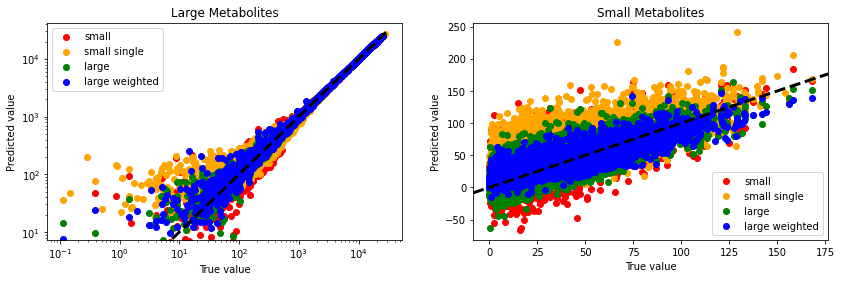

In [222]:
# Plot the scatter

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.scatter(y_val[:, :20], y_pred_small[:, :20], label='small', color='red')
plt.scatter(y_val_single[:20], y_pred_small_single[:20], label='small single', color='orange')
plt.scatter(y_val[:, :20], y_pred_big[:, :20], label='large', color='green')
plt.scatter(y_val[:, :20], y_pred_big_weigthed[:, :20], label='large weighted', color='blue')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("Large Metabolites")
plt.xlabel("True value")
plt.ylabel("Predicted value")

fig.add_subplot(122)
plt.scatter(y_val[:, 35:46], y_pred_small[:, 35:46], label='small', color='red')
plt.scatter(y_val_single[35:46], y_pred_small_single[35:46], label='small single', color='orange')
plt.scatter(y_val[:, 35:46], y_pred_big[:, 35:46], label='large', color='green')
plt.scatter(y_val[:, 35:46], y_pred_big_weigthed[:, 35:46], label='large weighted', color='blue')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.legend()
plt.title("Small Metabolites")
plt.xlabel("True value")
plt.ylabel("Predicted value")

plt.show()

# Interprete MLP

In [268]:
def saliency_map_multi(model, spectrum):
    """
    This function should compute the saliency map as described above.
    It should return the tuple (saliency_map, decoded_predictions).
    """
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(spectrum)
        preds = model(spectrum[tf.newaxis, ...])
        preds = tf.squeeze(preds)
        metabolites = [preds[i] for i in range(48)]
    sms = []
    for i in range(48):
        grads = tape.gradient(metabolites[i], spectrum)
        sms.append(tf.math.abs(grads))
    return sms, preds

def saliency_map_single(models, spectrum):
    """
    This function should compute the saliency map as described above.
    It should return the tuple (saliency_map, decoded_predictions).
    """
    sms = []
    for i in range(48):
        model = models[i]
        with tf.GradientTape() as tape:
            tape.watch(spectrum)
            preds = model(spectrum[tf.newaxis, ...])
            preds = tf.squeeze(preds)
        grads = tape.gradient(preds, spectrum)
        sms.append(tf.math.abs(grads))
    return sms, preds

In [281]:
df_spectrum_metabolites = []
for i in range(4):
    filename_spectrum_metabolite = '../data/Metabolite_spectrum/metabolite_{}.txt'.format(i)
    data_spectrum_metabolite = np.loadtxt(filename_spectrum_metabolite, dtype=float)
    df_spectrum_metabolites.append(pd.DataFrame(data_spectrum_metabolite))
for i in range(45, 47):
    filename_spectrum_metabolite = '../data/Metabolite_spectrum/metabolite_{}.txt'.format(i)
    data_spectrum_metabolite = np.loadtxt(filename_spectrum_metabolite, dtype=float)
    df_spectrum_metabolites.append(pd.DataFrame(data_spectrum_metabolite))

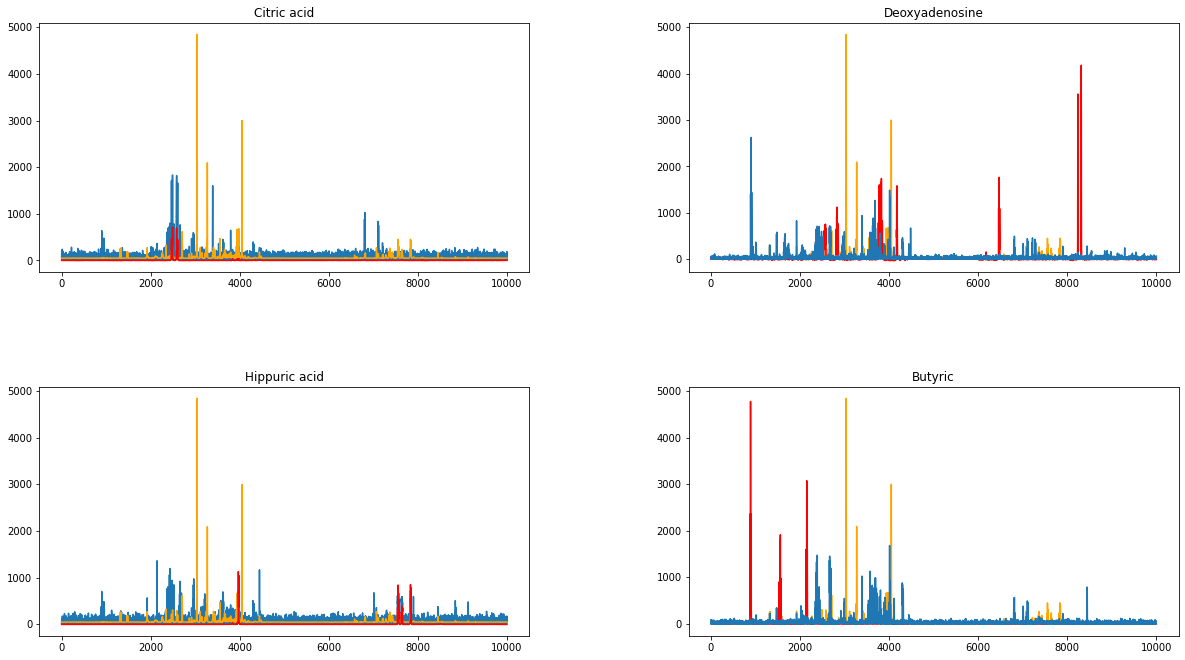

In [313]:
# Compute the saliency map for a randomly selected image
for parsed_record in test_dataset.shuffle(1000).take(1):
    random_spectrum = parsed_record[0][0]
    true_concentration = parsed_record[1][0].numpy()
    sms, pred_concentration = saliency_map_multi(large_multi_mlp, random_spectrum)


fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(sms[2] * 300)
axs[0, 0].plot(random_spectrum * 20000, color='orange')
axs[0, 0].plot(df_spectrum_metabolites[2], color='red')
axs[0, 0].set_title("Citric acid")
axs[1, 0].plot(sms[1] * 300)
axs[1, 0].plot(random_spectrum * 20000, color='orange')
axs[1, 0].plot(df_spectrum_metabolites[1], color='red')
axs[1, 0].set_title("Hippuric acid")
axs[0, 1].plot(random_spectrum * 20000, color='orange')
axs[0, 1].plot(df_spectrum_metabolites[4] * 4000, color='red')
axs[0, 1].plot(sms[45] * 300)
axs[0, 1].set_title("Deoxyadenosine")
axs[1, 1].plot(random_spectrum * 20000, color='orange')
axs[1, 1].plot(df_spectrum_metabolites[5] * 10000, color='red')
axs[1, 1].plot(sms[46] * 300)
axs[1, 1].set_title("Butyric")
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
# plt.figure(figsize=(12, 5))
# plt.plot(sms[46] * 500)
# plt.plot(random_spectrum * 20000, color='yellow')
# plt.plot(df_spectrum_creatinine, color='red')
# plt.title("Saliency map of metabolite {}".format(0))



plt.show()

# print("Model predictions:\n{}".format(decoded_preds))

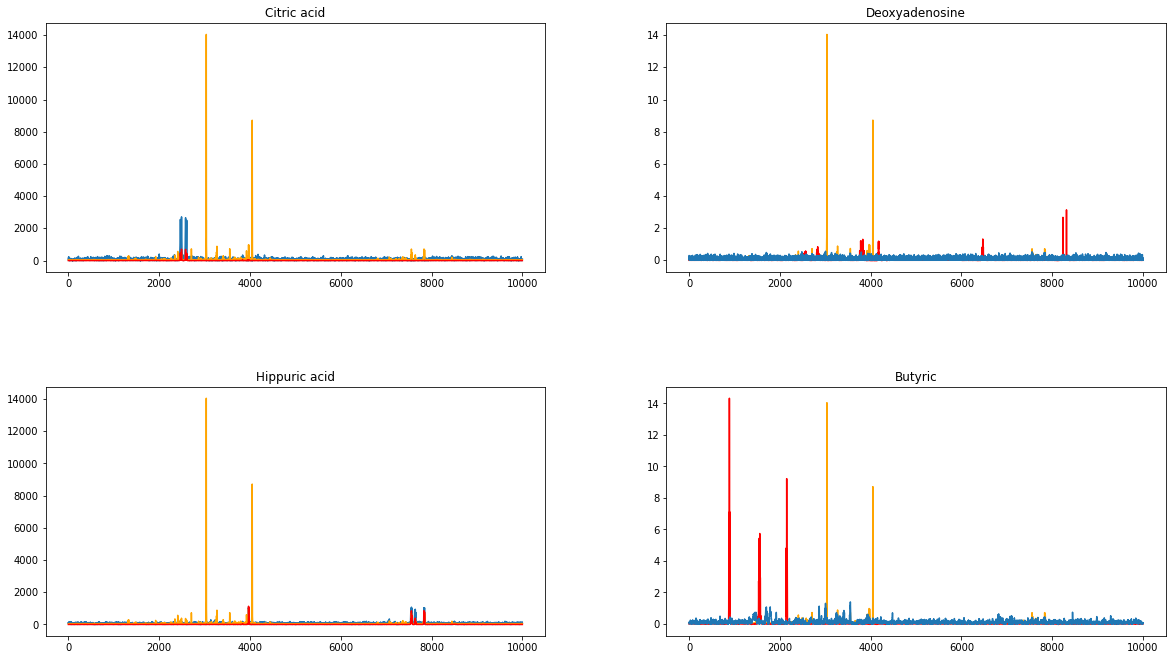

In [309]:
# Compute the saliency map for a randomly selected image
for parsed_record in test_dataset.shuffle(1000).take(1):
    random_spectrum = parsed_record[0][0]
    true_concentration = parsed_record[1][0].numpy()
    sms, pred_concentration = saliency_map_single(xsmall_inde_mlps, random_spectrum)



fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(sms[2] * 500)
axs[0, 0].plot(random_spectrum * 20000, color='orange')
axs[0, 0].plot(df_spectrum_metabolites[2], color='red')
axs[0, 0].set_title("Citric acid")
axs[1, 0].plot(sms[1] * 500)
axs[1, 0].plot(random_spectrum * 20000, color='orange')
axs[1, 0].plot(df_spectrum_metabolites[1], color='red')
axs[1, 0].set_title("Hippuric acid")
axs[0, 1].plot(random_spectrum * 20, color='orange')
axs[0, 1].plot(df_spectrum_metabolites[4] * 3, color='red')
axs[0, 1].plot(sms[45] * 10)
axs[0, 1].set_title("Deoxyadenosine")
axs[1, 1].plot(random_spectrum * 20, color='orange')
axs[1, 1].plot(df_spectrum_metabolites[5] * 30, color='red')
axs[1, 1].plot(sms[46])
axs[1, 1].set_title("Butyric")
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
# plt.figure(figsize=(12, 5))
# plt.plot(sms[46] * 500)
# plt.plot(random_spectrum * 20000, color='yellow')
# plt.plot(df_spectrum_creatinine, color='red')
# plt.title("Saliency map of metabolite {}".format(0))



plt.show()

# print("Model predictions:\n{}".format(decoded_preds))